In [1]:
%pip install numpy pillow pandas tensorflow keras matplotlib torch gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 43.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tsfresh 0.20.3 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
Note: you may need to restart the kernel to use 

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
import numpy as np
import pandas as pd
import joblib
import scipy.misc
import pickle
from PIL import Image
from skimage.transform import resize
import os
import json

In [2]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 60.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 86.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.4/568.4 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 4.2.4
    Uninstalling cachetools-4.2.4:
      Successfully uninstalled cachetools-4.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires ptxcompiler, which

In [3]:
import json
import pandas as pd 
import torch
from transformers import BertTokenizer, BertModel,pipeline
from sklearn.model_selection import train_test_split
import numpy as np
import time
import PIL
import tensorflow as tf
from PIL import Image
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate
from keras.optimizers import Adam
from matplotlib import pyplot as plt
import pickle
import os
import random
import torch
import torch.nn as nn
from torchvision import transforms
import ast

#mlflow
import mlflow
import mlflow.pytorch
from torchvision.utils import save_image

# **Embedding Layer For CUB2002011**

Extract The Caption Of Each Image 

In [4]:
def load_text(text_file_path):
    """
    Load text from a file and return it as a string.
    """
    with open(text_file_path, 'r', encoding='utf-8') as file:
        text = file.read().strip().split('\n')
    return text

def load_class_ids(class_info_file_path):
    """
    Load class ids from class_info.pickle file
    """
    with open(class_info_file_path, 'rb') as f:
        class_ids = pickle.load(f, encoding='latin1')
        return class_ids
      
def load_embeddings(embeddings_file_path):
    """
    Load embeddings
    """
    with open(embeddings_file_path, 'rb') as f:
        embeddings = pickle.load(f, encoding='latin1')
        embeddings = np.array(embeddings)
        print('embeddings: ', embeddings.shape)
    return embeddings
 
def load_filenames(filenames_file_path):
    """
    Load filenames.pickle file and return a list of all file names
    """
    with open(filenames_file_path, 'rb') as f:
        filenames = pickle.load(f, encoding='latin1')
    return filenames
 


def load_bounding_boxes(dataset_dir):
    """
    Load bounding boxes and return a dictionary of file names and corresponding bounding boxes
    """
    # Paths
    bounding_boxes_path = os.path.join(dataset_dir, 'bounding_boxes.txt')
    file_paths_path = os.path.join(dataset_dir, 'images.txt')

    # Read bounding_boxes.txt and images.txt file
    df_bounding_boxes = pd.read_csv(bounding_boxes_path,
                                    sep='\s+', header=None).astype(int)
    df_file_names = pd.read_csv(file_paths_path, sep='\s+', header=None)

    # Create a list of file names
    file_names = df_file_names[1].tolist()

    # Create a dictionary of file_names and bounding boxes
    filename_boundingbox_dict = {img_file[:-4]: [] for img_file in file_names[:2]}

    # Assign a bounding box to the corresponding image
    for i in range(0, len(file_names)):
        # Get the bounding box
        bounding_box = df_bounding_boxes.iloc[i][1:].tolist()
        key = file_names[i][:-4]
        filename_boundingbox_dict[key] = bounding_box

    return filename_boundingbox_dict


def get_img(img_path, bbox, image_size):
    """
    Load and resize image
    """
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        R = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - R)
        y2 = np.minimum(height, center_y + R)
        x1 = np.maximum(0, center_x - R)
        x2 = np.minimum(width, center_x + R)
        img = img.crop([x1, y1, x2, y2])
    img = img.resize(image_size, PIL.Image.BILINEAR)
    return img
def load_dataset(filenames_file_path, class_info_file_path, cub_dataset_dir,text_dir, embeddings_file_path, image_size):
    """
    Load dataset
    """
    filenames = load_filenames(filenames_file_path)
    class_ids = load_class_ids(class_info_file_path)
    bounding_boxes = load_bounding_boxes(cub_dataset_dir)
    all_embeddings = load_embeddings(embeddings_file_path)
    X, y, embeddings,texts = [], [], [],[]

    print("Embeddings shape:", all_embeddings.shape)

    for index, filename in enumerate(filenames):
        bounding_box = bounding_boxes[filename]
        

        try:
            # Load images
            img_name = '{}/images/{}.jpg'.format(cub_dataset_dir, filename)
            text_file= load_text('{}/text_c10/{}.txt'.format(text_dir, filename))
            img = get_img(img_name, bounding_box, image_size)
            all_embeddings1 = all_embeddings[index, :, :]

            embedding_ix = random.randint(0, all_embeddings1.shape[0] - 1)
            embedding = all_embeddings1[embedding_ix, :]
            text=text_file[embedding_ix]

            X.append(np.array(img))
            y.append(class_ids[index])
            embeddings.append(embedding)
            texts.append(text)
        except Exception as e:
            print(e)

    X = np.array(X)
    y = np.array(y)
    embeddings = np.array(embeddings)
    
    return X, y, embeddings,text

In [5]:
load_text("/kaggle/input/birdszip/birds/text_c10/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.txt")

['the medium sized bird has a dark grey color, a black downward curved beak, and long wings.',
 'the bird is dark grey brown with a thick curved bill and a flat shaped tail.',
 'bird has brown body feathers, white breast feathers and black beak',
 'this bird has a dark brown overall body color, with a small white patch around the base of the bill.',
 'the bird has very long and large brown wings, as well as a black body and a long black beak.',
 'it is a type of albatross with black wings, tail, back and beak, and has a white ring at the base of its beak.',
 'this bird has brown plumage and a white ring at the base of its long, curved brown beak.',
 'the entire body is dark brown, as is the bill, with a white band encircling where the bill meets the head.',
 'this bird is gray in color, with a large curved beak.',
 'a large gray bird with a long wingspan and a long black beak.']

In [6]:
train_image, train_label, train_embedding,train_text=load_dataset("/kaggle/input/birdszip/birds/train/filenames.pickle","/kaggle/input/birdszip/birds/train/class_info.pickle","/kaggle/input/cub2002011/CUB_200_2011","/kaggle/input/cub2002011/cvpr2016_cub","/kaggle/input/birdszip/birds/train/char-CNN-RNN-embeddings.pickle",(64,64))

embeddings:  (8855, 10, 1024)
Embeddings shape: (8855, 10, 1024)


In [7]:
test_image, test_label, test_embedding,test_text=load_dataset("/kaggle/input/birdszip/birds/train/filenames.pickle","/kaggle/input/birdszip/birds/train/class_info.pickle","/kaggle/input/cub2002011/CUB_200_2011","/kaggle/input/cub2002011/cvpr2016_cub","/kaggle/input/birdszip/birds/train/char-CNN-RNN-embeddings.pickle",(64,64))


embeddings:  (8855, 10, 1024)
Embeddings shape: (8855, 10, 1024)


In [8]:
train_df=pd.DataFrame({
    "image":list(train_image),
    "train_text":train_text,
    "vector_emb":list(train_embedding)
})
train_df.head()

image  \
0  [[[104, 131, 143], [121, 142, 154], [134, 151,...   
1  [[[53, 63, 69], [74, 83, 86], [79, 87, 89], [7...   
2  [[[83, 103, 23], [80, 102, 26], [87, 111, 19],...   
3  [[[150, 148, 153], [153, 151, 156], [155, 153,...   
4  [[[78, 69, 67], [83, 72, 71], [75, 63, 62], [5...   

                                          train_text  \
0  this bird has wings that are brown and has a y...   
1  this bird has wings that are brown and has a y...   
2  this bird has wings that are brown and has a y...   
3  this bird has wings that are brown and has a y...   
4  this bird has wings that are brown and has a y...   

                                          vector_emb  
0  [-0.20583372, 0.20465058, 0.13165587, -0.06379...  
1  [-0.29646197, 0.1440824, 0.28118563, 0.0293142...  
2  [0.2544848, 0.112521246, 0.056623276, 0.097706...  
3  [-0.15316086, 0.17782697, 0.106462754, -0.0847...  
4  [-0.02236132, -0.025680661, 0.47425216, 0.1033...

In [9]:
test_df=pd.DataFrame({
    "image":list(test_image),
    "test_text":test_text,
    "vector_emb":list(test_embedding)
})
test_df.head()

image  \
0  [[[104, 131, 143], [121, 142, 154], [134, 151,...   
1  [[[53, 63, 69], [74, 83, 86], [79, 87, 89], [7...   
2  [[[83, 103, 23], [80, 102, 26], [87, 111, 19],...   
3  [[[150, 148, 153], [153, 151, 156], [155, 153,...   
4  [[[78, 69, 67], [83, 72, 71], [75, 63, 62], [5...   

                                           test_text  \
0  this yellow breasted bird has a black cheek pa...   
1  this yellow breasted bird has a black cheek pa...   
2  this yellow breasted bird has a black cheek pa...   
3  this yellow breasted bird has a black cheek pa...   
4  this yellow breasted bird has a black cheek pa...   

                                          vector_emb  
0  [-0.10245901, 0.08354798, -0.055076048, -0.040...  
1  [-0.13848011, 0.1029341, 0.112114534, 0.040126...  
2  [0.1231875, 0.13404414, 0.056584906, 0.0648051...  
3  [-0.008370306, 0.07140453, -0.049068503, -0.01...  
4  [-0.02236132, -0.025680661, 0.47425216, 0.1033...

# **Conditioning Augmentation**

In [10]:
class CA_NET(nn.Module):
    def __init__(self, embedding_text_dim=1024, c_dim=128, device='cuda'):
        super(CA_NET, self).__init__()
        self.embedding_text_dim = embedding_text_dim
        self.c_dim = c_dim
        self.device = device  # Save device as a class attribute
        self.fc = nn.Linear(embedding_text_dim, c_dim * 2, bias=True).to(self.device)
        self.relu = nn.ReLU().to(self.device)
            
    def encode(self, text_embedding):
        text_embedding = text_embedding.to(self.device)
        x = self.relu(self.fc(text_embedding))  # reducing the text embedding dimension to 256 then using LRLU
        mean = x[:, :self.c_dim]  # take the first 128 to be the mean
        log_variance = x[:, self.c_dim:]  # take the last 128 to be the log variance
        return mean, log_variance

    def reparametrize(self, mean, log_variance):
        std = log_variance.mul(0.5).exp_()  # calculating the std from the log_variance through taking the exp then the sqrt
        eps = torch.randn_like(std)      
        return eps.mul(std).add_(mean)  # create c: eps*std + mean
        
        
    def forward(self, text_embedding):
        mean, log_variance = self.encode(text_embedding)
        c = self.reparametrize(mean, log_variance)
        return c, mean, log_variance  # c (128,128)


# **Stage 1**

In [11]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


# Upsale the spatial size by a factor of 2
def upBlock(in_planes, out_planes):
    block = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        conv3x3(in_planes, out_planes),
        nn.BatchNorm2d(out_planes),
        nn.ReLU(True))
    return block


In [12]:
class D_GET_LOGITS(nn.Module):
    def __init__(self, ndf, nef,device='cuda'):
        super(D_GET_LOGITS, self).__init__()
        self.df_dim = ndf #64
        self.ef_dim = nef #128
        self.device = device
        
        self.outlogits = nn.Sequential(
            conv3x3(ndf * 8 + nef, ndf * 8), # 640 , 512
            nn.BatchNorm2d(ndf * 8), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
            nn.Sigmoid()).to(self.device)
           
            
    def forward(self, h_code, c_code=None):
        # conditioning output
        if  c_code is not None:
            c_code = c_code.view(-1, self.ef_dim, 1, 1) #reshape
            c_code = c_code.repeat(1, 1, 4, 4) # transforming its shape
            # state size (ngf+egf) x 4 x 4
            h_c_code = torch.cat((h_code, c_code), 1)

        else:
            h_c_code = h_code
        output = self.outlogits(h_c_code)

        return output.view(-1)#flattenning
    


### **Generative**

In [13]:
class STAGE1_G(nn.Module):
    def __init__(self, device='cuda'):
        super(STAGE1_G, self).__init__()
        self.device = device
        self.gf_dim = 128 * 8  # 128 * 8 = 1024
        self.ef_dim = 128  # 128
        self.z_dim = 100  # 100
        self.define_module()

    def define_module(self):
        ninput = self.z_dim + self.ef_dim  # 100 + 128 = 228
        ngf = self.gf_dim  # 1024 
        self.ca_net = CA_NET(device=self.device).to(self.device)

        # -> ngf x 4 x 4 == 1024 x 4 x 4
        self.fc = nn.Sequential(
            nn.Linear(ninput, ngf * 4 * 4, bias=False),
            nn.BatchNorm1d(ngf * 4 * 4),
            nn.ReLU(True)).to(self.device)

        # ngf x 4 x 4 -> ngf/2 x 8 x 8
        self.upsample1 = upBlock(ngf, ngf // 2).to(self.device)
        # -> ngf/4 x 16 x 16
        self.upsample2 = upBlock(ngf // 2, ngf // 4).to(self.device)
        # -> ngf/8 x 32 x 32
        self.upsample3 = upBlock(ngf // 4, ngf // 8).to(self.device)
        # -> ngf/16 x 64 x 64
        self.upsample4 = upBlock(ngf // 8, ngf // 16).to(self.device)
        # -> 3 x 64 x 64
        self.img = nn.Sequential(
            conv3x3(ngf // 16, 3),
            nn.Tanh()).to(self.device)

    def forward(self, text_embedding, noise):
        
        c_code, mu, logvar = self.ca_net(text_embedding)
        z_c_code = torch.cat((noise, c_code), 1).to(self.device)
        h_code = self.fc(z_c_code)

        h_code = h_code.view(-1, self.gf_dim, 4, 4)
        h_code = self.upsample1(h_code)
        h_code = self.upsample2(h_code)
        h_code = self.upsample3(h_code)
        h_code = self.upsample4(h_code)
        # state size 3 x 64 x 64
        fake_img = self.img(h_code)
        return fake_img, mu, logvar


### **Discriminative**

In [14]:
class STAGE1_D(nn.Module):
    def __init__(self, device='cuda'):
        super(STAGE1_D, self).__init__()
        self.device = device
        self.df_dim = 64  # 64
        self.ef_dim = 128  # 128
        self.define_module()

    def define_module(self):
        ndf, nef = self.df_dim, self.ef_dim  # 64, 128
        self.encode_img = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            # state size (ndf * 8) x 4 x 4)
            nn.LeakyReLU(0.2, inplace=True)
        ).to(self.device)

        self.get_cond_logits = D_GET_LOGITS(ndf, nef, device=self.device).to(self.device)  # 64, 128
        self.get_uncond_logits = None

    def forward(self, image):
        img_embedding = self.encode_img(image)
        return img_embedding


In [15]:
def KL_loss(mu, logvar):
    # Calculate the KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(KLD)


### **Data Preperation**

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
from torchvision import transforms

class MyDataset(Dataset):
    def __init__(self, dataframe, imsize=64, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.imsize = imsize
        self.data = dataframe

    def get_img(self, image_data):
        """
        Load and transform the image.
        """
        if isinstance(image_data, str):
            img = Image.open(image_data).convert('RGB')
        elif isinstance(image_data, np.ndarray):
            img = Image.fromarray(image_data)
        else:
            raise TypeError("Unsupported image data type.")
        
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __getitem__(self, index):
        row = self.data.iloc[index]
        # Convert the string representation of the vector to a list of floats
        vector = row['vector_emb']
        # Convert to a numpy array
#         vector = np.array([float(x) for x in vector_str.strip('[]').split() if x])
        embedding = torch.tensor(vector, dtype=torch.float32)
        img = self.get_img(row['image'])
        if self.target_transform is not None:
            embedding = self.target_transform(embedding)
        comment = row['train_text']
        return img, embedding, comment

    def __len__(self):
        return len(self.data)

In [17]:
train_df.head()

image  \
0  [[[104, 131, 143], [121, 142, 154], [134, 151,...   
1  [[[53, 63, 69], [74, 83, 86], [79, 87, 89], [7...   
2  [[[83, 103, 23], [80, 102, 26], [87, 111, 19],...   
3  [[[150, 148, 153], [153, 151, 156], [155, 153,...   
4  [[[78, 69, 67], [83, 72, 71], [75, 63, 62], [5...   

                                          train_text  \
0  this bird has wings that are brown and has a y...   
1  this bird has wings that are brown and has a y...   
2  this bird has wings that are brown and has a y...   
3  this bird has wings that are brown and has a y...   
4  this bird has wings that are brown and has a y...   

                                          vector_emb  
0  [-0.20583372, 0.20465058, 0.13165587, -0.06379...  
1  [-0.29646197, 0.1440824, 0.28118563, 0.0293142...  
2  [0.2544848, 0.112521246, 0.056623276, 0.097706...  
3  [-0.15316086, 0.17782697, 0.106462754, -0.0847...  
4  [-0.02236132, -0.025680661, 0.47425216, 0.1033...

In [18]:
# Define the image transformations
transform = transforms.Compose([
    transforms.RandomCrop(64),  # Randomly crop the image to the specified size
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally (data augmentation)
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])


# Create Dataset objects
train_dataset =MyDataset(dataframe=train_df, transform=transform)

test_dataset = MyDataset(dataframe=test_df ,transform=transform)


# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)




In [19]:
def weights_init(m):
    classname = m.__class__.__name__  # Get the class name of the layer/module
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0.0)
            
            
'''
The function checks the class of each layer (module) in the model and applies a different initialization method based on
whether it's a convolutional layer (Conv), a batch normalization layer (BatchNorm), or a linear (fully connected) layer (Linear).

'''

"\nThe function checks the class of each layer (module) in the model and applies a different initialization method based on\nwhether it's a convolutional layer (Conv), a batch normalization layer (BatchNorm), or a linear (fully connected) layer (Linear).\n\n"

# **Training For The First 150 Epochs**

In [20]:
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Define the device
num_epochs = 100
lr_decay_step = 600
generator_lr = 2e-4
discriminator_lr = 2e-4

# Instantiate the networks
Gen1 = STAGE1_G(device=device)
Gen1.apply(weights_init)
Dis1 = STAGE1_D(device=device)
Dis1.apply(weights_init)

# Define optimizers
opt_d1 = torch.optim.Adam(Dis1.parameters(), lr=generator_lr, betas=(0.5, 0.999))
opt_g1 = torch.optim.Adam(Gen1.parameters(), lr=discriminator_lr, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()
#It compares predicted probabilities with true binary labels and calculates how well the model is performing.



In [113]:
import torchvision

# Function to denormalize and plot images
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Assuming the images were normalized to [-1, 1]
    return tensor.clamp(0, 1)

def plot_images(images, nrow=4, title='Images', figsize=(15, 15)):
    images = denormalize(images)
    grid_img = torchvision.utils.make_grid(images.cpu(), nrow=nrow, padding=2)
    plt.figure(figsize=figsize)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()


2024/10/20 14:25:03 INFO mlflow.tracking.fluent: Experiment with name 'GAN_Training_Project' does not exist. Creating a new experiment.


Epoch [1/150], Discriminator Loss: 1.4794153189487596, Generator Loss: 3.2589565322553513


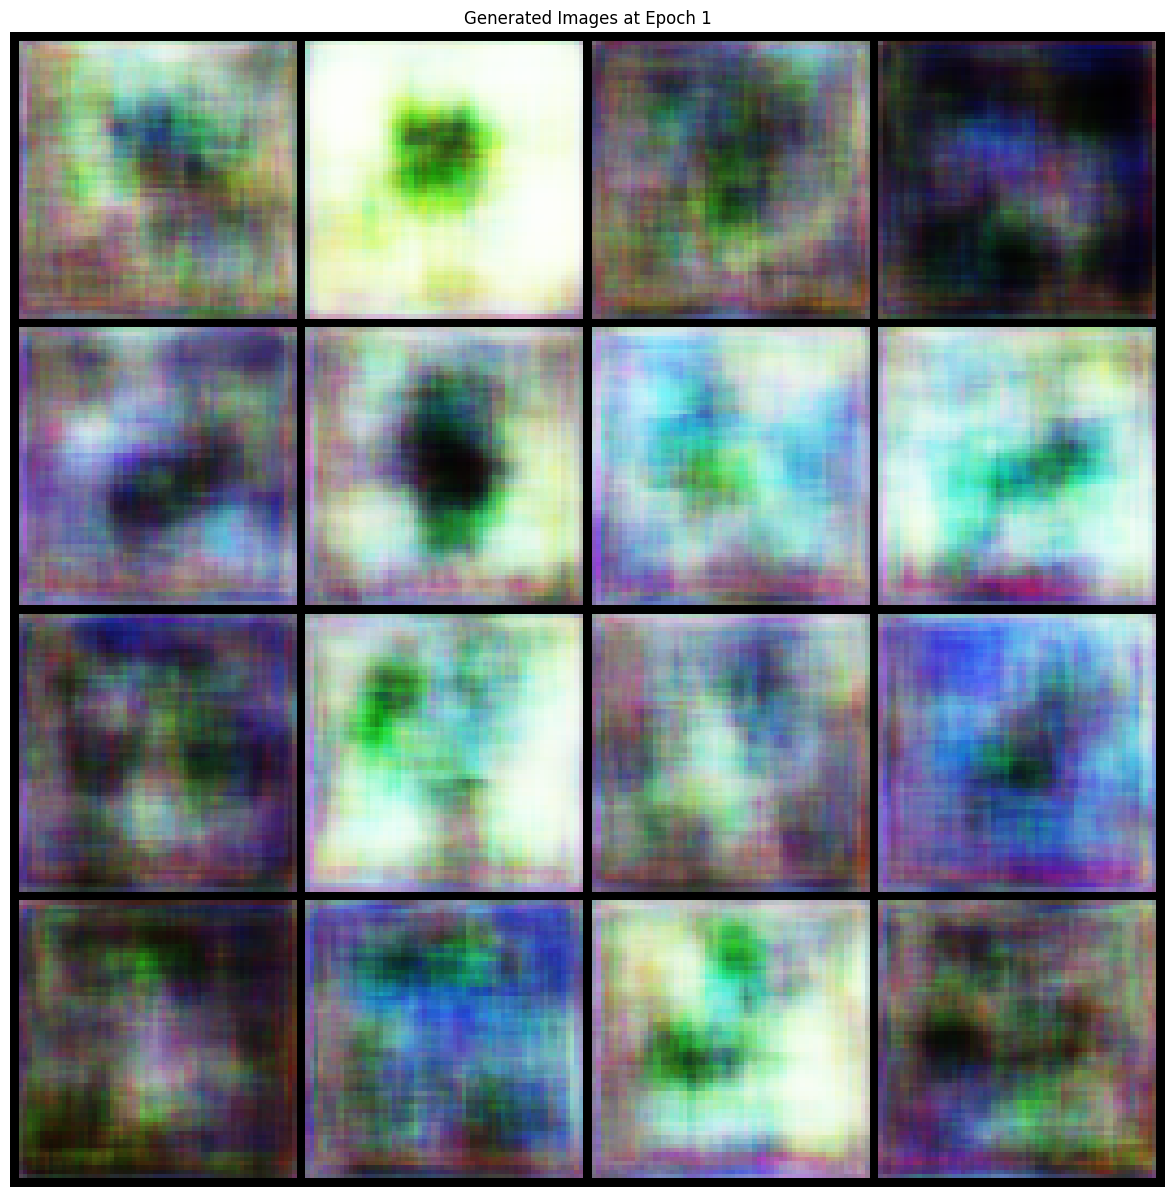

Epoch [2/150], Discriminator Loss: 1.3798477829789086, Generator Loss: 1.4105353359695818
Epoch [3/150], Discriminator Loss: 1.3071053697050905, Generator Loss: 1.4383822475834716
Epoch [4/150], Discriminator Loss: 1.261318850431511, Generator Loss: 1.499520181323127
Epoch [5/150], Discriminator Loss: 1.2739743920538922, Generator Loss: 1.2210727539851511
Epoch [6/150], Discriminator Loss: 1.2411373356263415, Generator Loss: 1.1886317226097738
Epoch [7/150], Discriminator Loss: 1.2148830890655518, Generator Loss: 1.223071283573727
Epoch [8/150], Discriminator Loss: 1.1797243215197282, Generator Loss: 1.242769094465448
Epoch [9/150], Discriminator Loss: 1.1188511428215522, Generator Loss: 1.2214078881757722
Epoch [10/150], Discriminator Loss: 1.0654748763969477, Generator Loss: 1.2790570475643488
Epoch [11/150], Discriminator Loss: 1.0659045684251853, Generator Loss: 1.2597529733781334


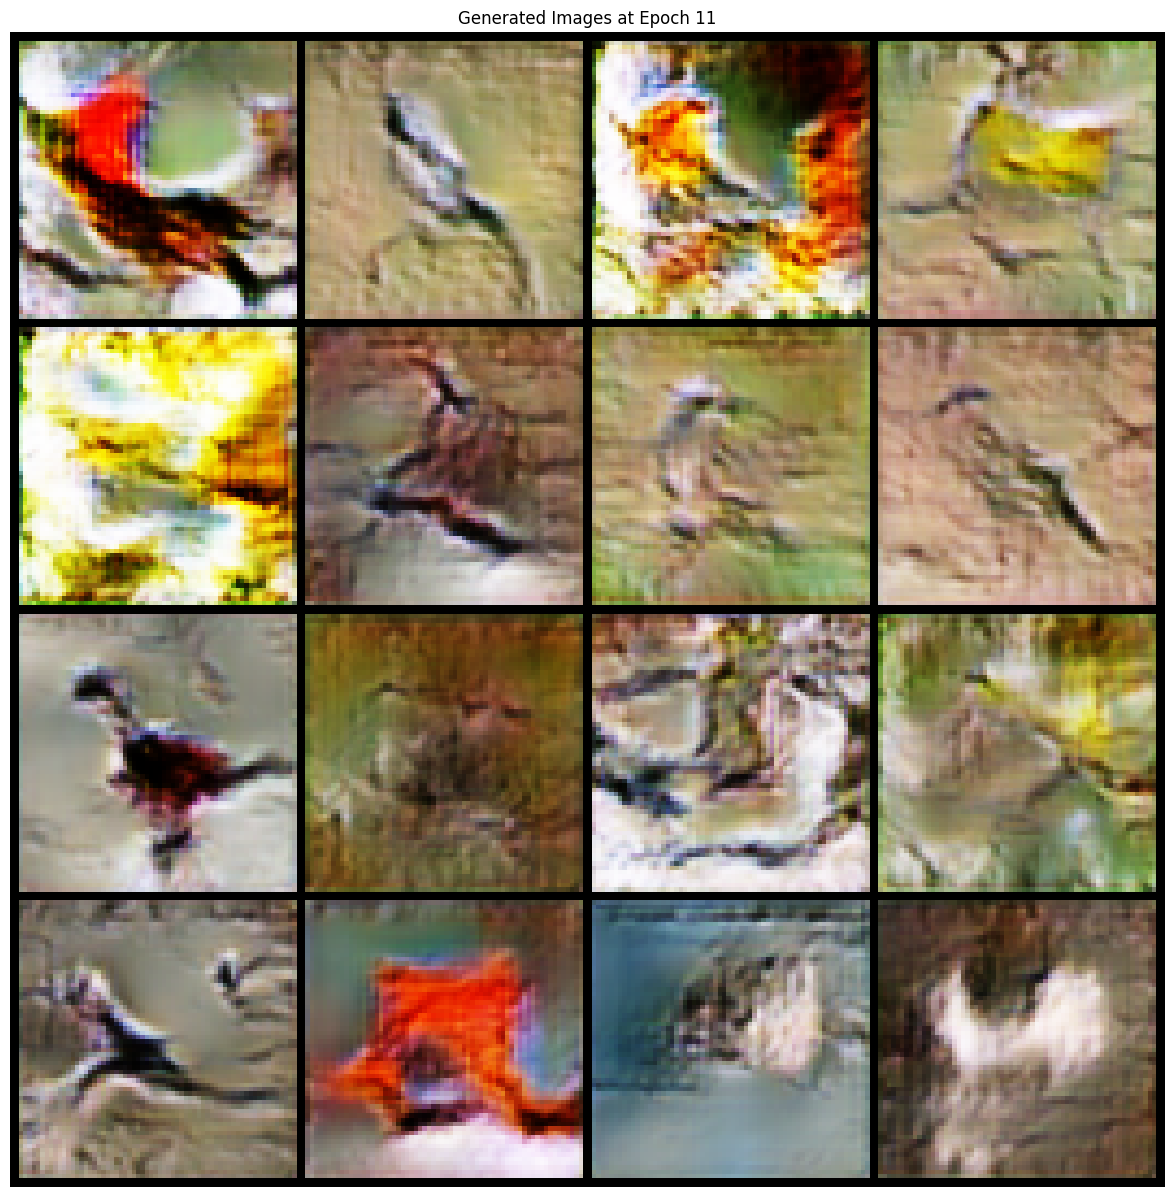

Epoch [12/150], Discriminator Loss: 1.0477125567497967, Generator Loss: 1.1603136909522598
Epoch [13/150], Discriminator Loss: 1.0662500652477895, Generator Loss: 1.1004383075151511
Epoch [14/150], Discriminator Loss: 1.023969756184722, Generator Loss: 1.043118388103924
Epoch [15/150], Discriminator Loss: 1.032642800602124, Generator Loss: 1.0130761062069762
Epoch [16/150], Discriminator Loss: 1.0153366923332214, Generator Loss: 1.0773972280377107
Epoch [17/150], Discriminator Loss: 0.9652187811384956, Generator Loss: 1.0758142184010513
Epoch [18/150], Discriminator Loss: 0.9645793296450333, Generator Loss: 1.118768688157308
Epoch [19/150], Discriminator Loss: 0.9690414963008689, Generator Loss: 1.156263722254218
Epoch [20/150], Discriminator Loss: 0.9164755751760744, Generator Loss: 1.170214371286708
Epoch [21/150], Discriminator Loss: 0.8866301487675674, Generator Loss: 1.1913640471242315


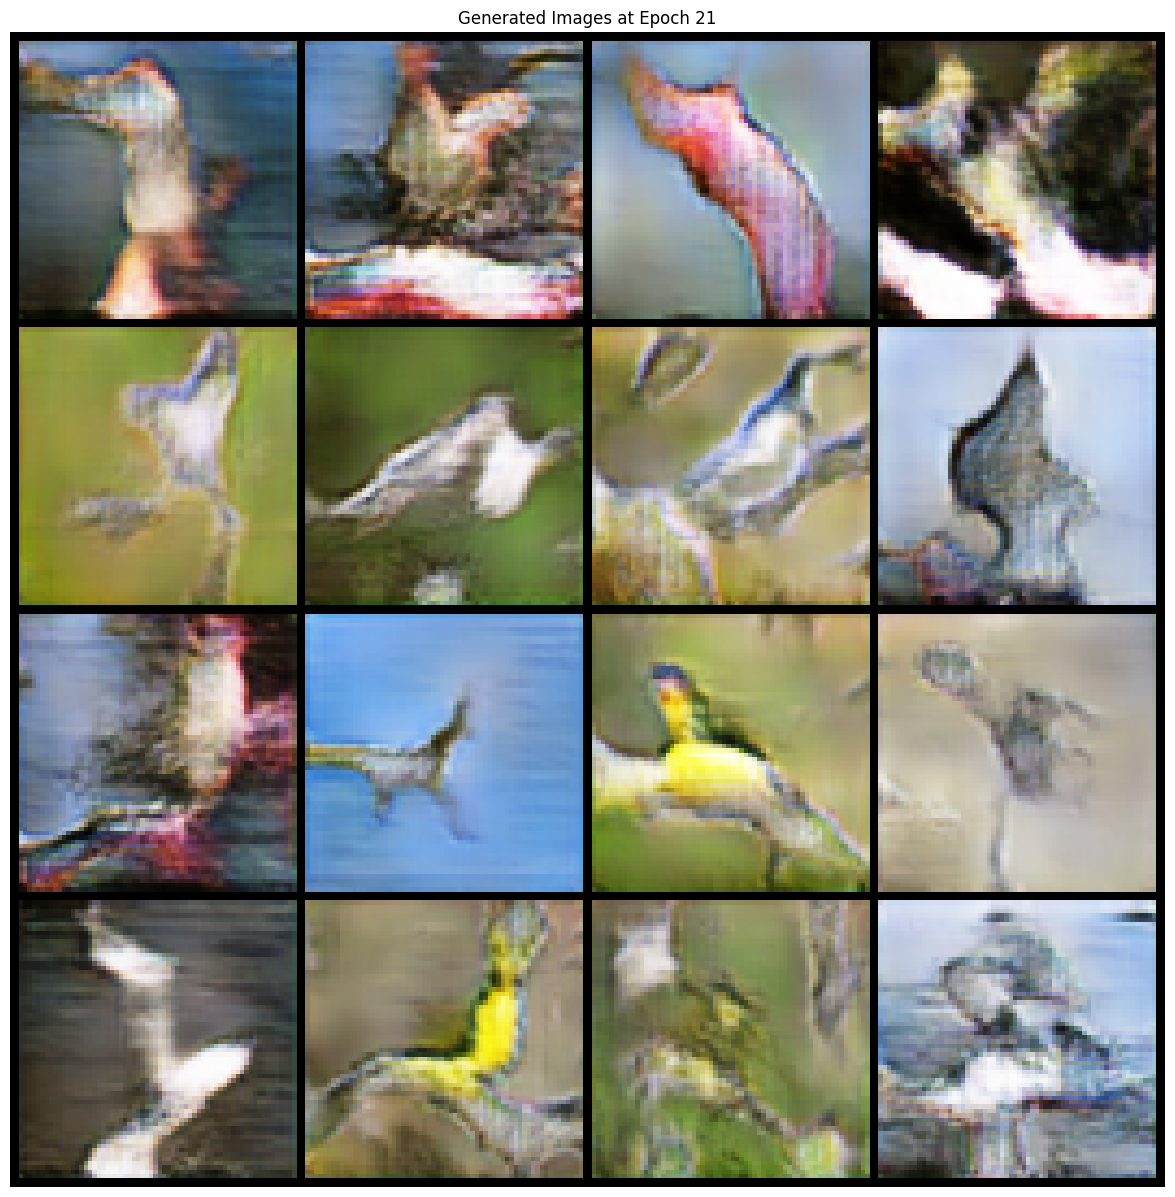

Epoch [22/150], Discriminator Loss: 0.8344333643535916, Generator Loss: 1.258970375219695
Epoch [23/150], Discriminator Loss: 0.8501902857272745, Generator Loss: 1.3625267315253937
Epoch [24/150], Discriminator Loss: 0.8162007117442948, Generator Loss: 1.3674243751832906
Epoch [25/150], Discriminator Loss: 0.8046039059865389, Generator Loss: 1.4830628223985218
Epoch [26/150], Discriminator Loss: 0.7751322864628524, Generator Loss: 1.5210428752487513
Epoch [27/150], Discriminator Loss: 0.7720821804279904, Generator Loss: 1.5557193891178789
Epoch [28/150], Discriminator Loss: 0.7316135864892452, Generator Loss: 1.547198747559417
Epoch [29/150], Discriminator Loss: 0.7066008727327525, Generator Loss: 1.6852411608473004
Epoch [30/150], Discriminator Loss: 0.6532697175904144, Generator Loss: 1.7080079728750874
Epoch [31/150], Discriminator Loss: 0.6488425774539975, Generator Loss: 1.7924326002168998


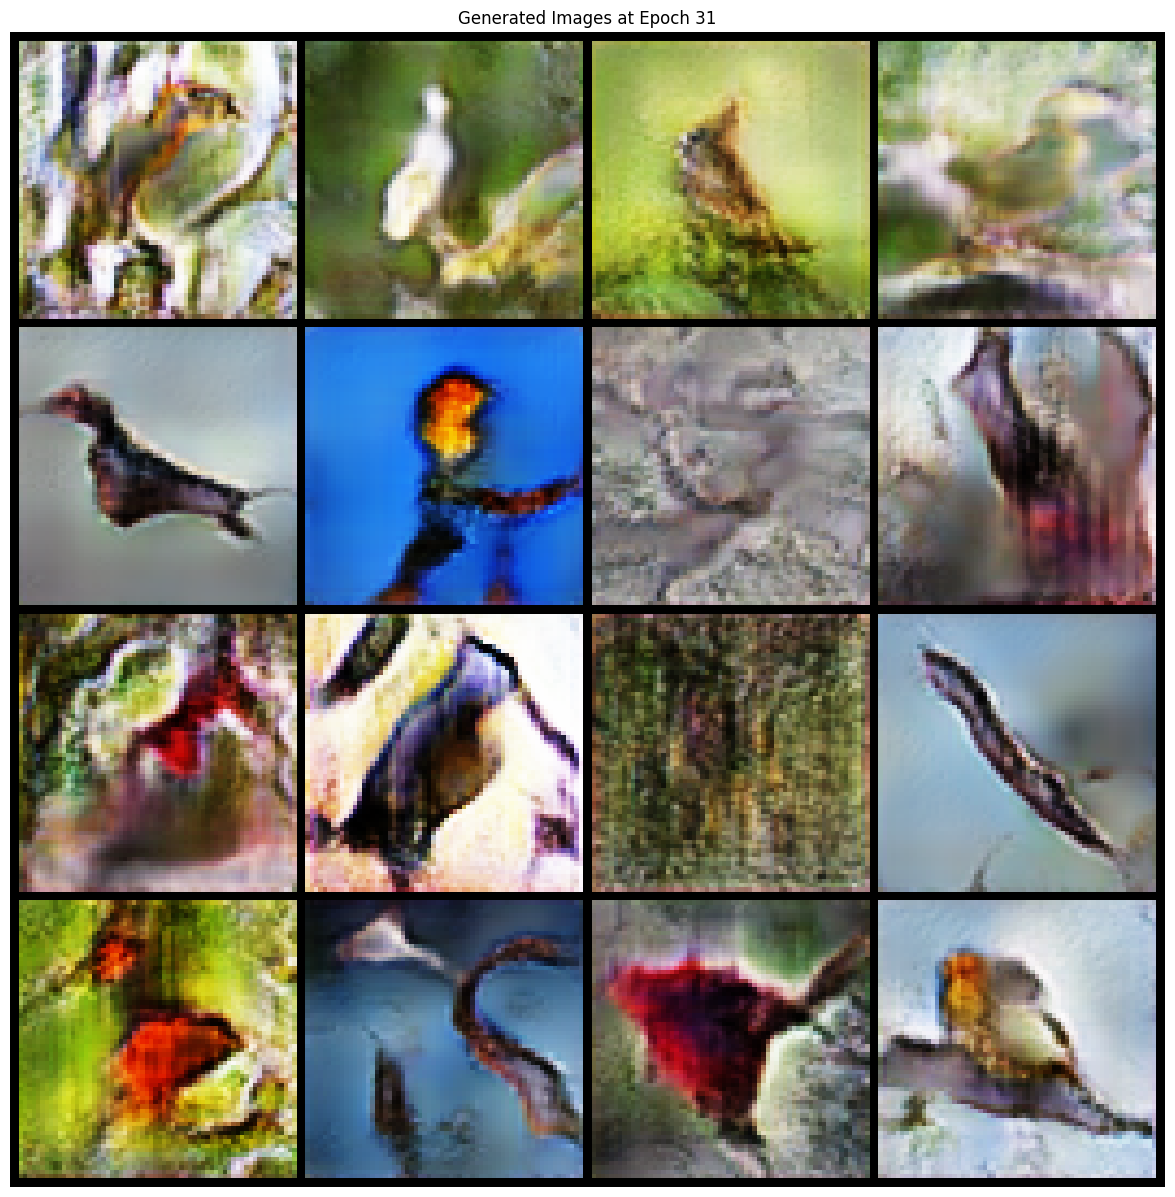

Epoch [32/150], Discriminator Loss: 0.6563893076327207, Generator Loss: 1.7487267332968952
Epoch [33/150], Discriminator Loss: 0.6820180218854397, Generator Loss: 1.7504130475383868
Epoch [34/150], Discriminator Loss: 0.5895974171890629, Generator Loss: 1.8881469752719935
Epoch [35/150], Discriminator Loss: 0.5716067661913179, Generator Loss: 1.8805606567816768
Epoch [36/150], Discriminator Loss: 0.5682579157806986, Generator Loss: 2.015539672734926
Epoch [37/150], Discriminator Loss: 0.5147193425850902, Generator Loss: 1.964883572870879
Epoch [38/150], Discriminator Loss: 0.5426768257463579, Generator Loss: 2.0915865730896273
Epoch [46/150], Discriminator Loss: 0.4027482491495798, Generator Loss: 2.774421569897974
Epoch [47/150], Discriminator Loss: 0.3415641115723754, Generator Loss: 2.828263459445761
Epoch [48/150], Discriminator Loss: 0.30212928756749885, Generator Loss: 2.941967674296537
Epoch [49/150], Discriminator Loss: 0.32871145208319313, Generator Loss: 2.9503137586410526
Ep

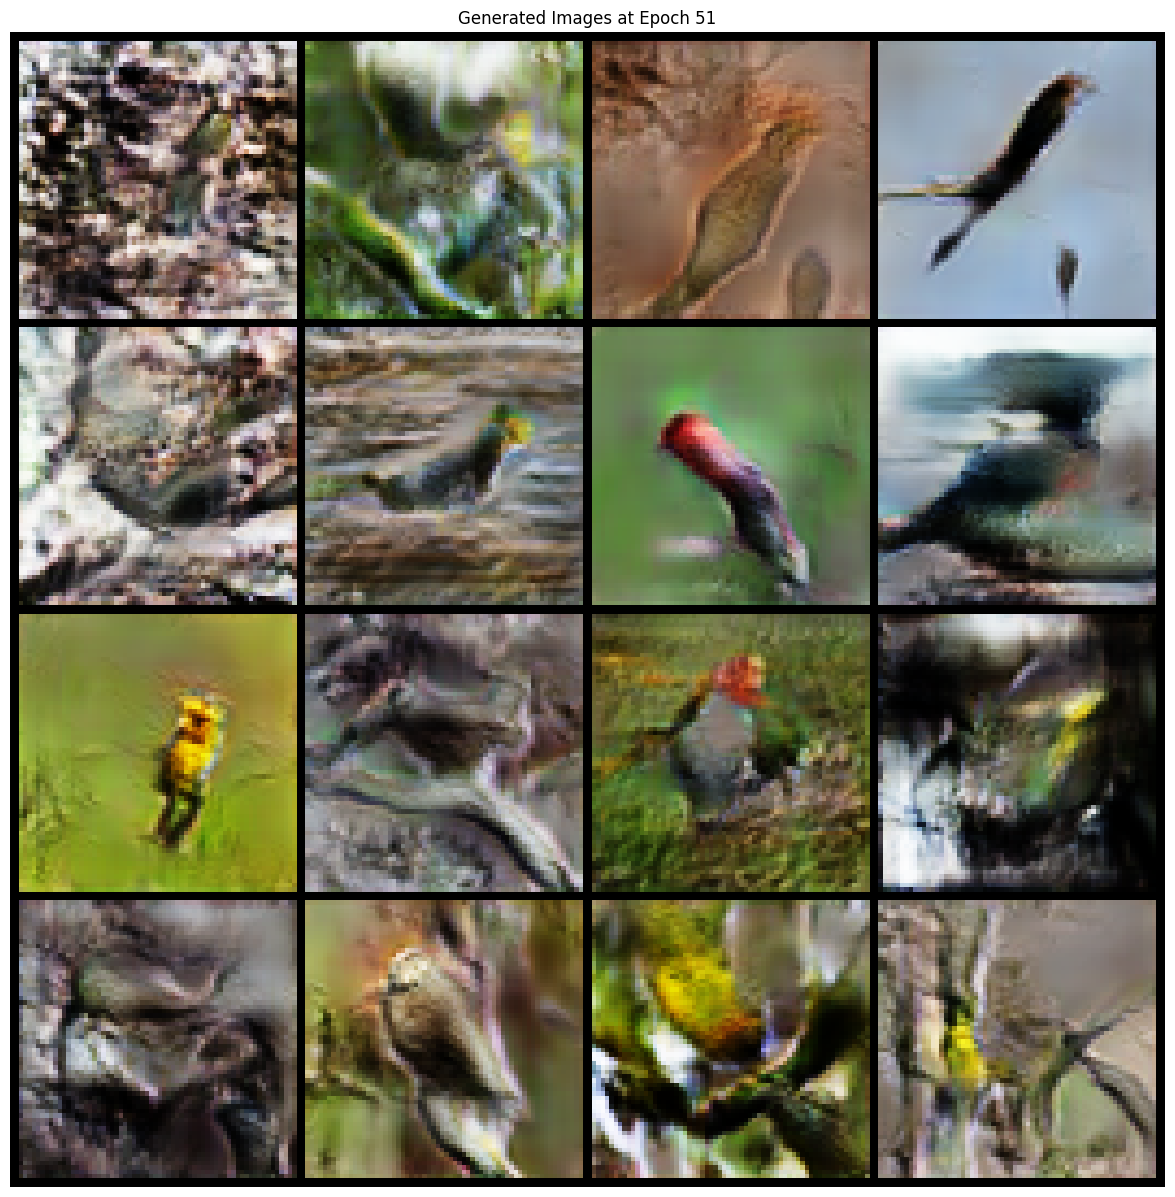

Epoch [52/150], Discriminator Loss: 0.20280160216225995, Generator Loss: 3.6067342728161984
Epoch [53/150], Discriminator Loss: 1.0698088678739053, Generator Loss: 2.1091874753587323
Epoch [54/150], Discriminator Loss: 0.3094253805901507, Generator Loss: 2.7203283041930026
Epoch [55/150], Discriminator Loss: 0.2746637854859126, Generator Loss: 3.0318168680444897
Epoch [56/150], Discriminator Loss: 0.25724916763121275, Generator Loss: 3.2137587199108206
Epoch [57/150], Discriminator Loss: 0.22522065477619926, Generator Loss: 3.4747809205981466
Epoch [58/150], Discriminator Loss: 0.13974447953079244, Generator Loss: 3.7639530125281793
Epoch [59/150], Discriminator Loss: 0.2804741896688938, Generator Loss: 3.6175967139734637
Epoch [60/150], Discriminator Loss: 0.4701104598294059, Generator Loss: 3.284737953045171
Epoch [61/150], Discriminator Loss: 0.15225227048499979, Generator Loss: 3.5967444970453384


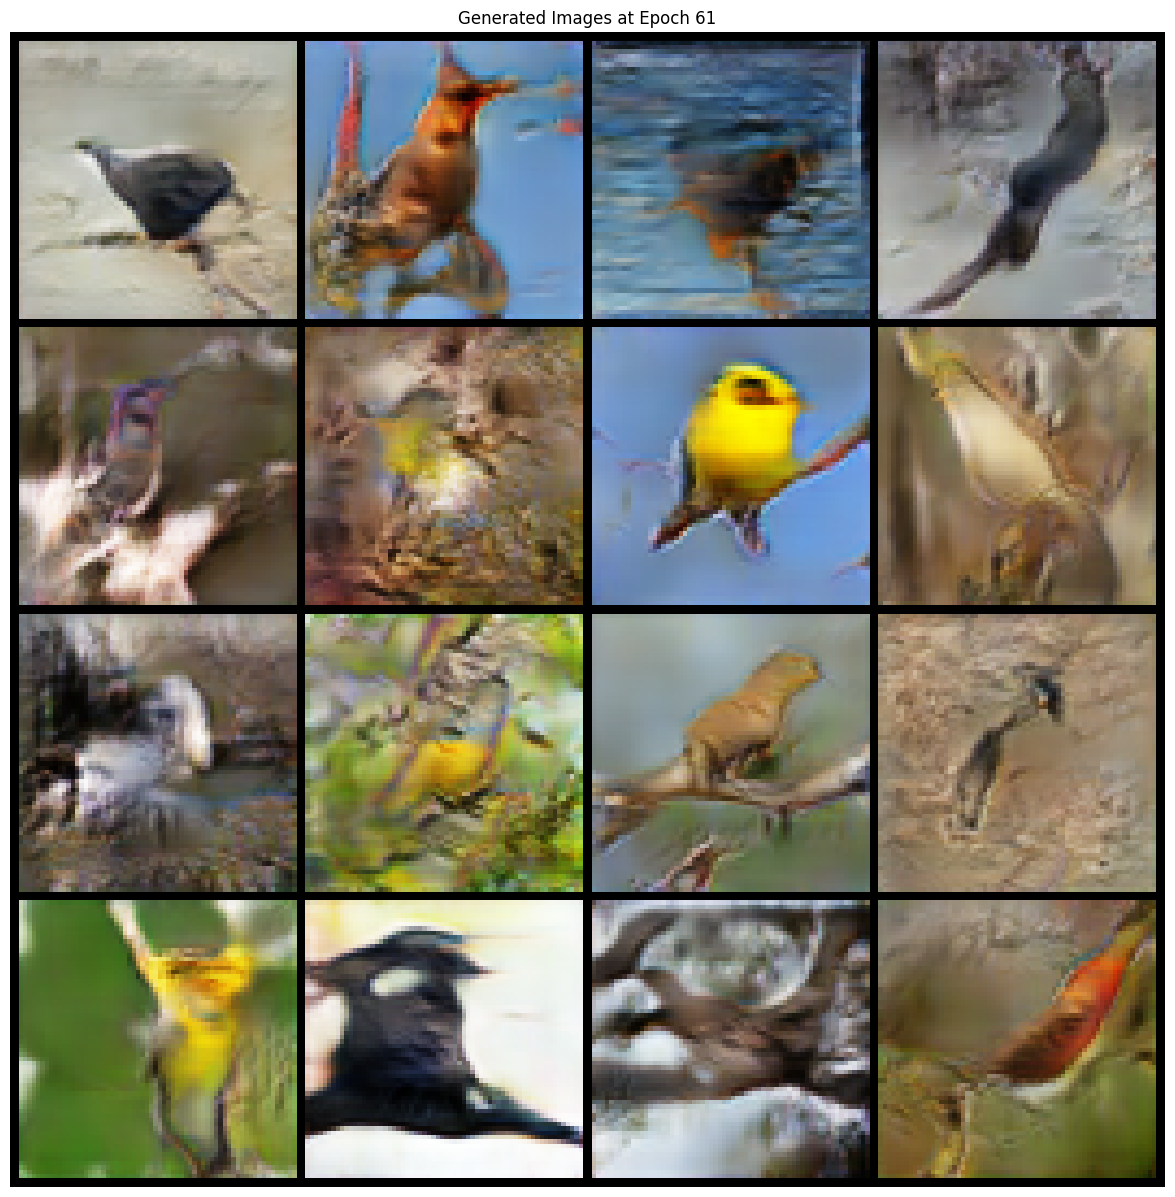

Epoch [62/150], Discriminator Loss: 0.14802371179886, Generator Loss: 3.904407632865494
Epoch [63/150], Discriminator Loss: 0.12881594440705485, Generator Loss: 4.072754903662976
Epoch [64/150], Discriminator Loss: 0.5190129577309537, Generator Loss: 3.3809529936088505
Epoch [65/150], Discriminator Loss: 0.2722951873011297, Generator Loss: 3.494440086185932
Epoch [66/150], Discriminator Loss: 0.1474120195874636, Generator Loss: 3.9314624448474365
Epoch [67/150], Discriminator Loss: 0.14906788337305724, Generator Loss: 3.976631640959129
Epoch [68/150], Discriminator Loss: 0.19413140587669483, Generator Loss: 4.418896885977374
Epoch [69/150], Discriminator Loss: 0.26869155353993823, Generator Loss: 3.6355054031173104
Epoch [70/150], Discriminator Loss: 0.12393785564215493, Generator Loss: 4.165444352215142
Epoch [71/150], Discriminator Loss: 0.32641710399938145, Generator Loss: 3.902317803594277


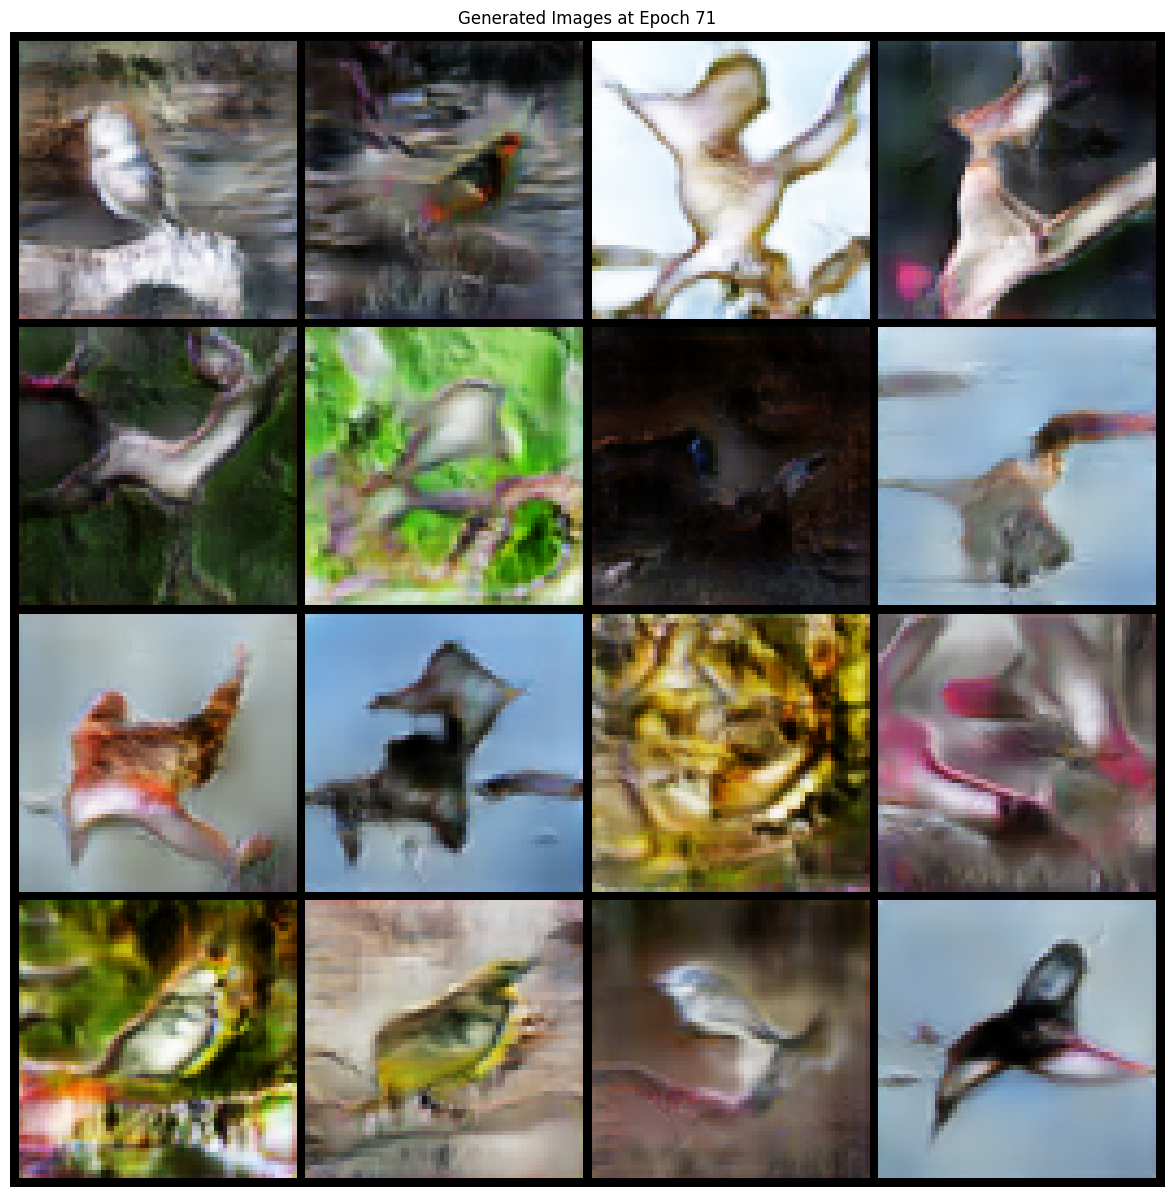

Epoch [72/150], Discriminator Loss: 0.14235756343914022, Generator Loss: 4.223202330603017
Epoch [73/150], Discriminator Loss: 0.0878480289587014, Generator Loss: 4.2323961862557224
Epoch [74/150], Discriminator Loss: 0.0795726426240566, Generator Loss: 4.512151735292064
Epoch [75/150], Discriminator Loss: 0.5735870145140685, Generator Loss: 4.09380599419861
Epoch [76/150], Discriminator Loss: 0.2037562483506237, Generator Loss: 3.7926474578088993
Epoch [77/150], Discriminator Loss: 0.1167212312089668, Generator Loss: 4.3761315765998345
Epoch [78/150], Discriminator Loss: 0.08026468622491514, Generator Loss: 4.397197293720657
Epoch [79/150], Discriminator Loss: 0.4831008936861436, Generator Loss: 3.802841878409008
Epoch [80/150], Discriminator Loss: 0.1088640942311973, Generator Loss: 4.025094140347817
Epoch [81/150], Discriminator Loss: 0.406450327948111, Generator Loss: 4.28274616972282


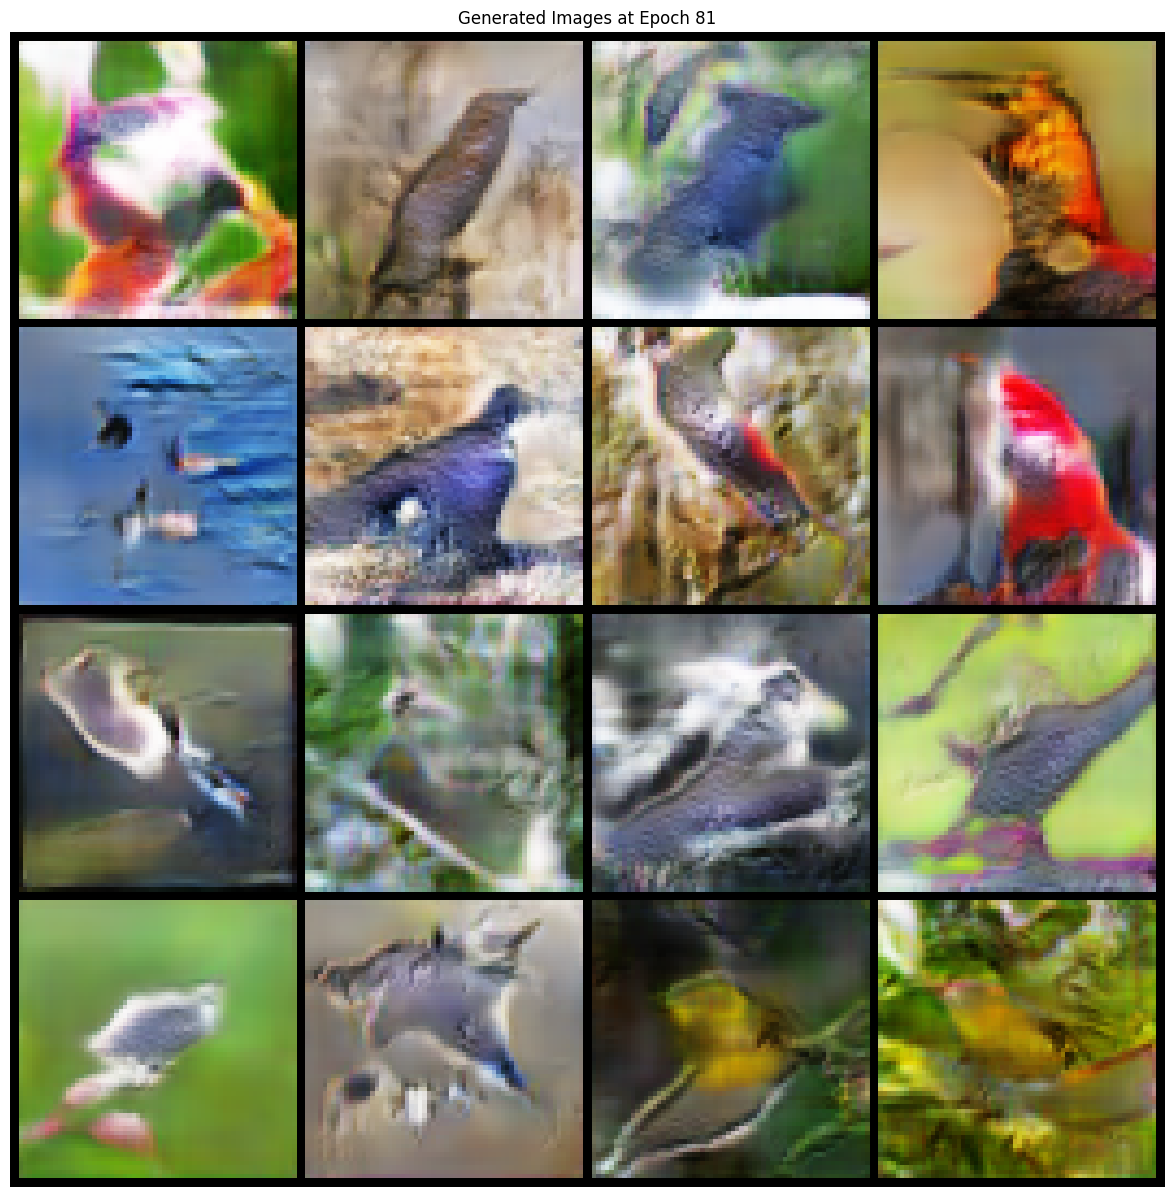

Epoch [82/150], Discriminator Loss: 0.3375443690757957, Generator Loss: 3.284426139413024
Epoch [83/150], Discriminator Loss: 0.10070131516767492, Generator Loss: 4.036071294503246
Epoch [84/150], Discriminator Loss: 0.07934708895979167, Generator Loss: 4.417211971694617
Epoch [85/150], Discriminator Loss: 0.05572488455088447, Generator Loss: 4.569202785011676
Epoch [86/150], Discriminator Loss: 0.5934882446949323, Generator Loss: 3.7921506435658094
Epoch [87/150], Discriminator Loss: 0.18179704072020894, Generator Loss: 3.8545523234408536
Epoch [88/150], Discriminator Loss: 0.13785639287327692, Generator Loss: 4.15790870035295
Epoch [89/150], Discriminator Loss: 0.21686589630762879, Generator Loss: 4.501282957603606
Epoch [90/150], Discriminator Loss: 0.11989070772588682, Generator Loss: 4.365865054748041
Epoch [91/150], Discriminator Loss: 0.06505822068040105, Generator Loss: 4.636858851789571


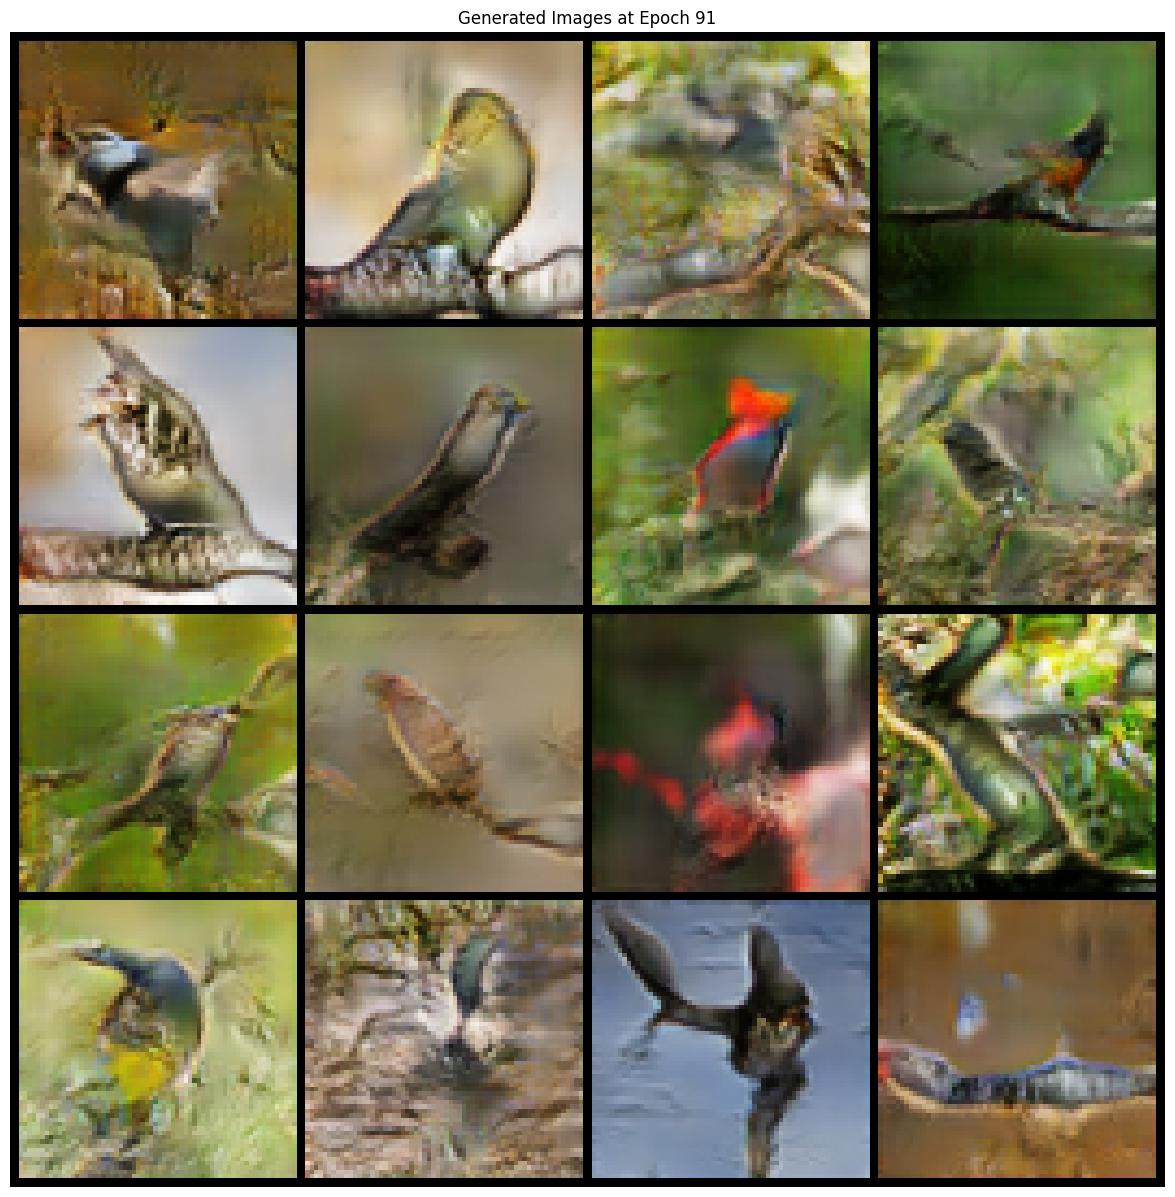

Epoch [92/150], Discriminator Loss: 0.05690285052916558, Generator Loss: 4.8745883171506925
Epoch [93/150], Discriminator Loss: 0.19769071621431722, Generator Loss: 4.847721587196529
Epoch [94/150], Discriminator Loss: 0.258322647096013, Generator Loss: 4.129663809597921
Epoch [95/150], Discriminator Loss: 0.0813878066770786, Generator Loss: 4.520427446571185
Epoch [96/150], Discriminator Loss: 0.12422531335648122, Generator Loss: 5.003863024197036
Epoch [97/150], Discriminator Loss: 0.05349007491424358, Generator Loss: 5.081748475273736
Epoch [98/150], Discriminator Loss: 0.05408518680994459, Generator Loss: 5.162556097661849
Epoch [99/150], Discriminator Loss: 0.2980059985165223, Generator Loss: 5.366008224568779
Epoch [100/150], Discriminator Loss: 0.16632295417324675, Generator Loss: 4.667579002731996
Epoch [101/150], Discriminator Loss: 0.10197669884739377, Generator Loss: 4.872038640564294


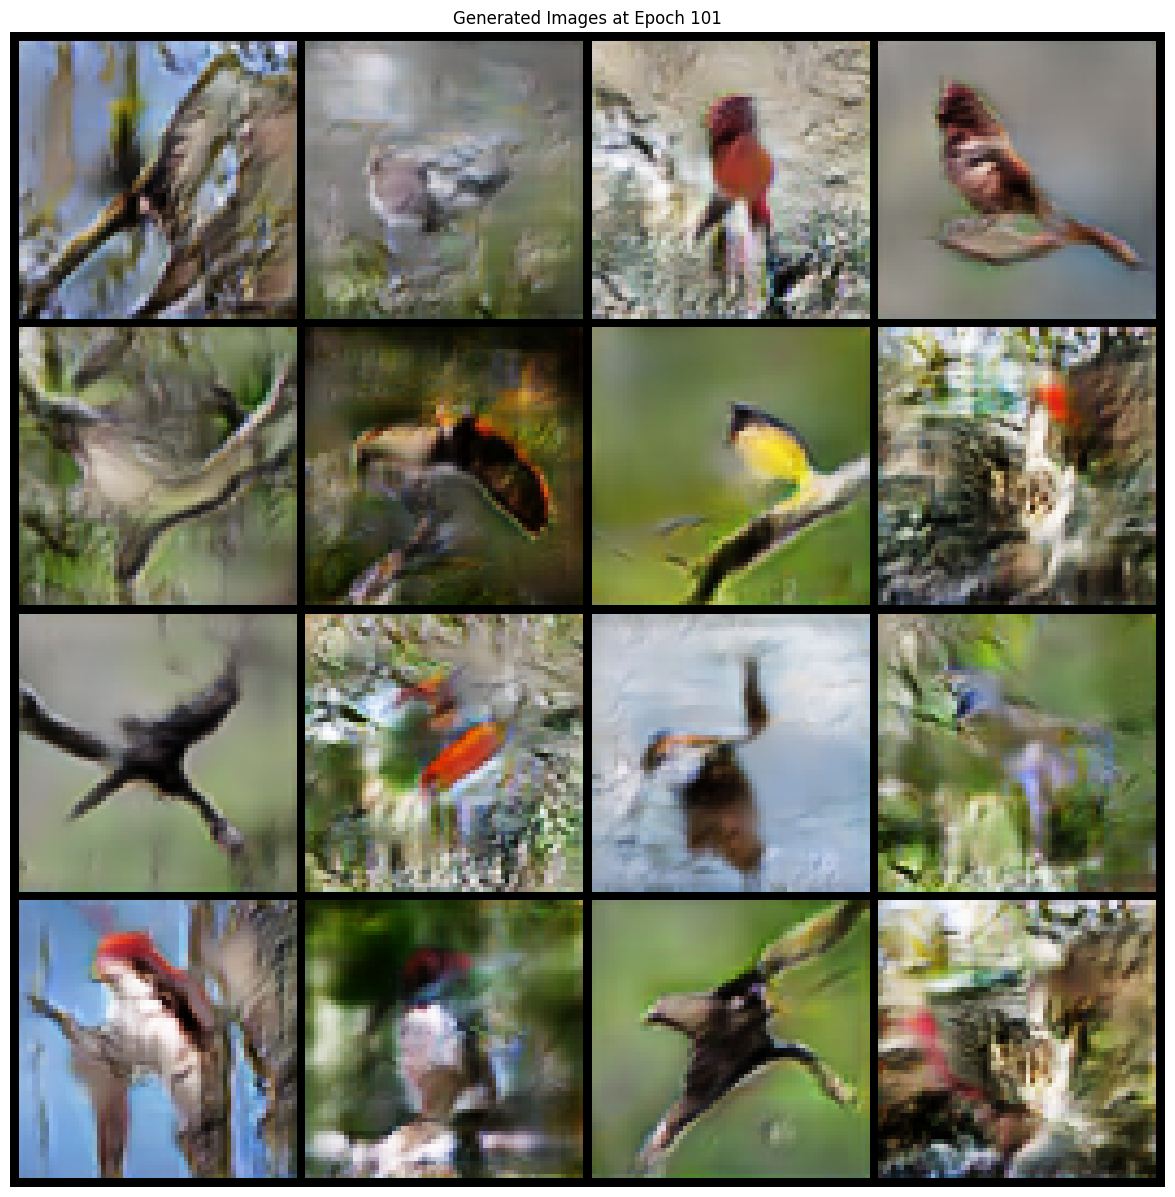

Epoch [102/150], Discriminator Loss: 0.11470485705775109, Generator Loss: 5.256387619234675
Epoch [103/150], Discriminator Loss: 0.3599112567444928, Generator Loss: 4.350141625904994
Epoch [104/150], Discriminator Loss: 0.18406760273836284, Generator Loss: 4.6707927703107
Epoch [105/150], Discriminator Loss: 0.07608865713365644, Generator Loss: 4.751248580946339
Epoch [106/150], Discriminator Loss: 0.06253091588937978, Generator Loss: 5.194388063691503
Epoch [107/150], Discriminator Loss: 0.058523573205813015, Generator Loss: 5.098137539067714
Epoch [108/150], Discriminator Loss: 0.040714171986437314, Generator Loss: 5.480560740120977
Epoch [109/150], Discriminator Loss: 0.16112107956085167, Generator Loss: 5.842760388799708
Epoch [110/150], Discriminator Loss: 0.07917112283234437, Generator Loss: 5.671426028656445
Epoch [111/150], Discriminator Loss: 0.10611987749128032, Generator Loss: 5.838855724754951


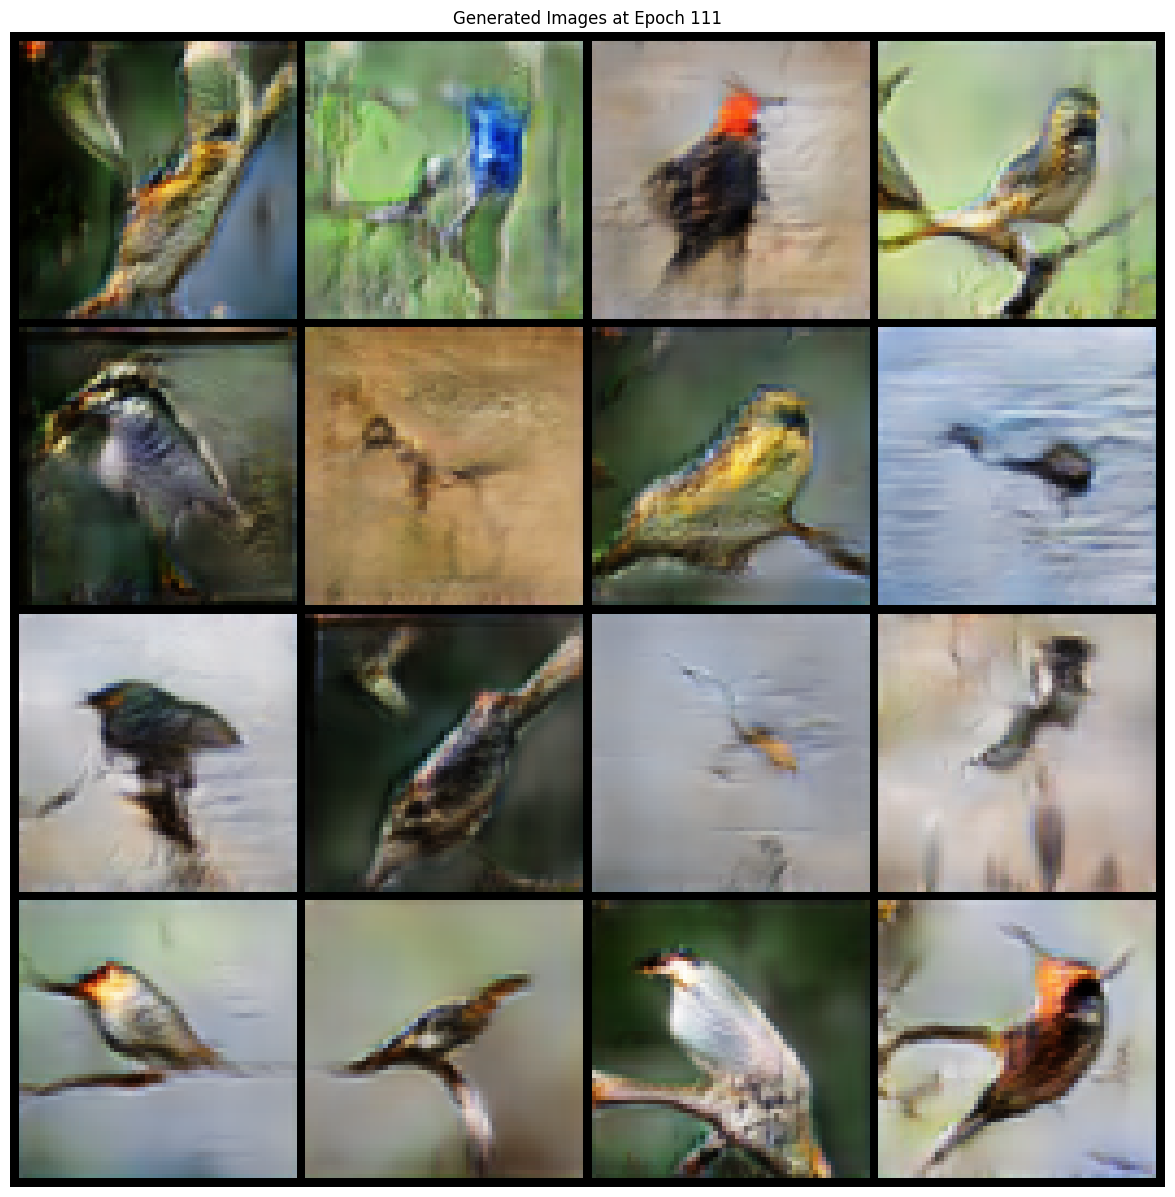

Epoch [112/150], Discriminator Loss: 0.07496572172322827, Generator Loss: 5.812963512304018
Epoch [113/150], Discriminator Loss: 0.04639892531190362, Generator Loss: 5.586275109284216
Epoch [114/150], Discriminator Loss: 0.6004292191736561, Generator Loss: 4.633551240280579
Epoch [115/150], Discriminator Loss: 0.09621411438682954, Generator Loss: 4.751801919594086
Epoch [116/150], Discriminator Loss: 0.09197228032720389, Generator Loss: 5.35811634115178
Epoch [117/150], Discriminator Loss: 0.04969588888929688, Generator Loss: 5.3107544466745935
Epoch [118/150], Discriminator Loss: 0.37050574092971655, Generator Loss: 5.033623107420883
Epoch [119/150], Discriminator Loss: 0.14458008345028908, Generator Loss: 4.700828963046451
Epoch [120/150], Discriminator Loss: 0.10625010032689186, Generator Loss: 5.23468399230096
Epoch [121/150], Discriminator Loss: 0.05491795965383271, Generator Loss: 5.150961163339855


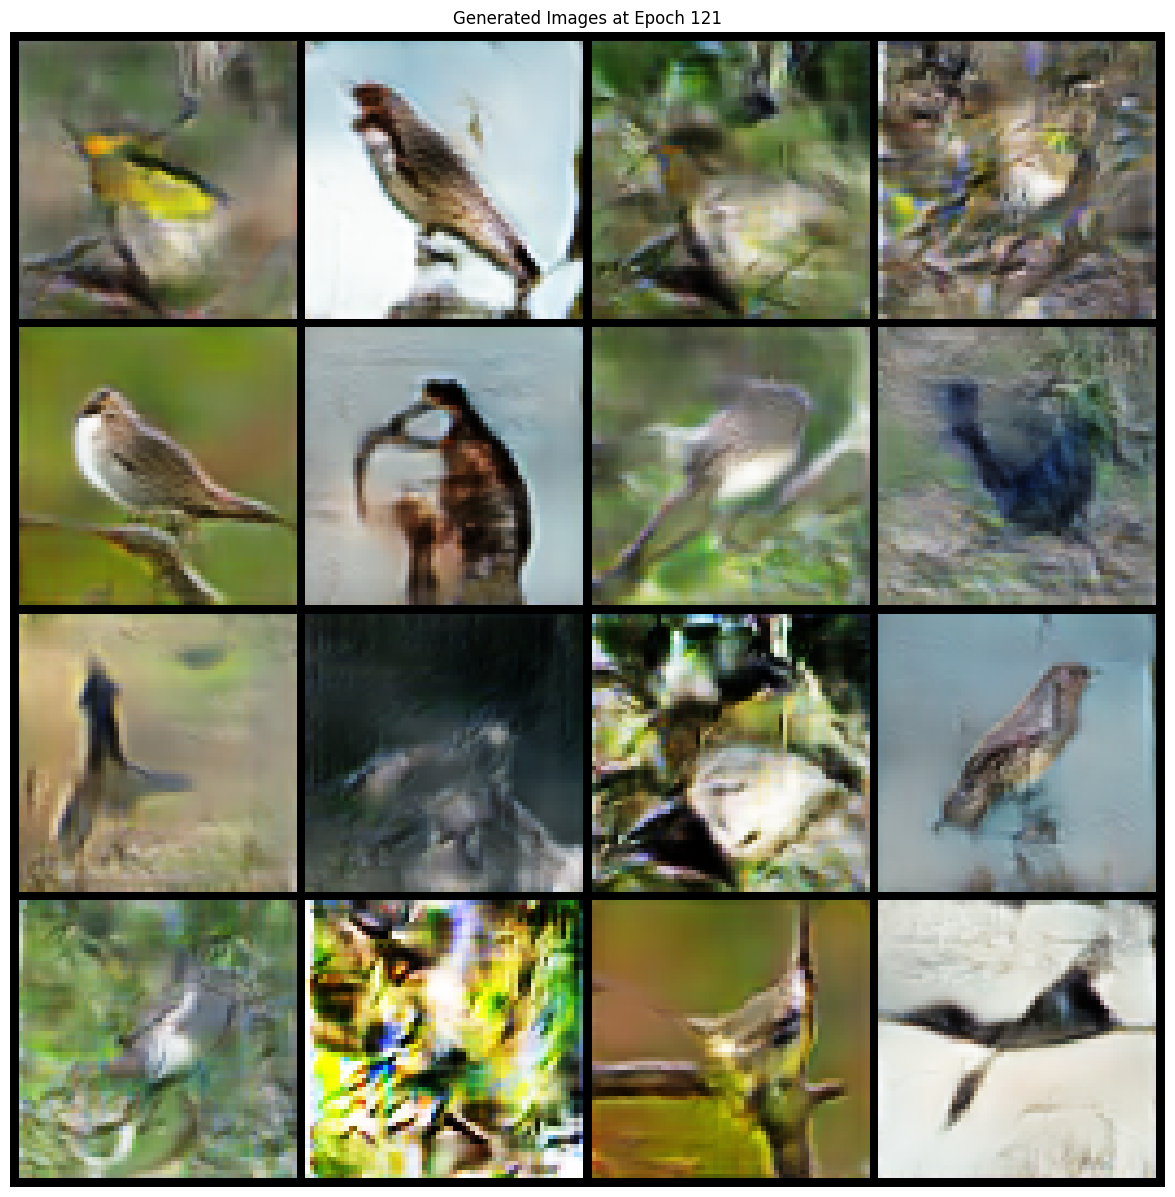

Epoch [122/150], Discriminator Loss: 0.08957860590019029, Generator Loss: 5.643852992023495
Epoch [123/150], Discriminator Loss: 0.04332231034410836, Generator Loss: 5.520104570354489
Epoch [124/150], Discriminator Loss: 0.044741845053198524, Generator Loss: 5.99993440573164
Epoch [125/150], Discriminator Loss: 0.03472395057173566, Generator Loss: 6.047379914805186
Epoch [126/150], Discriminator Loss: 0.2571038583531413, Generator Loss: 6.330169904159663
Epoch [127/150], Discriminator Loss: 0.33912172152412884, Generator Loss: 4.415301279198352
Epoch [128/150], Discriminator Loss: 0.09258565317383773, Generator Loss: 5.361324364332844
Epoch [129/150], Discriminator Loss: 0.05485816358876743, Generator Loss: 5.444026820093608
Epoch [130/150], Discriminator Loss: 0.22163674795812519, Generator Loss: 5.537906958580875
Epoch [131/150], Discriminator Loss: 0.2558551588122525, Generator Loss: 5.003096041244056


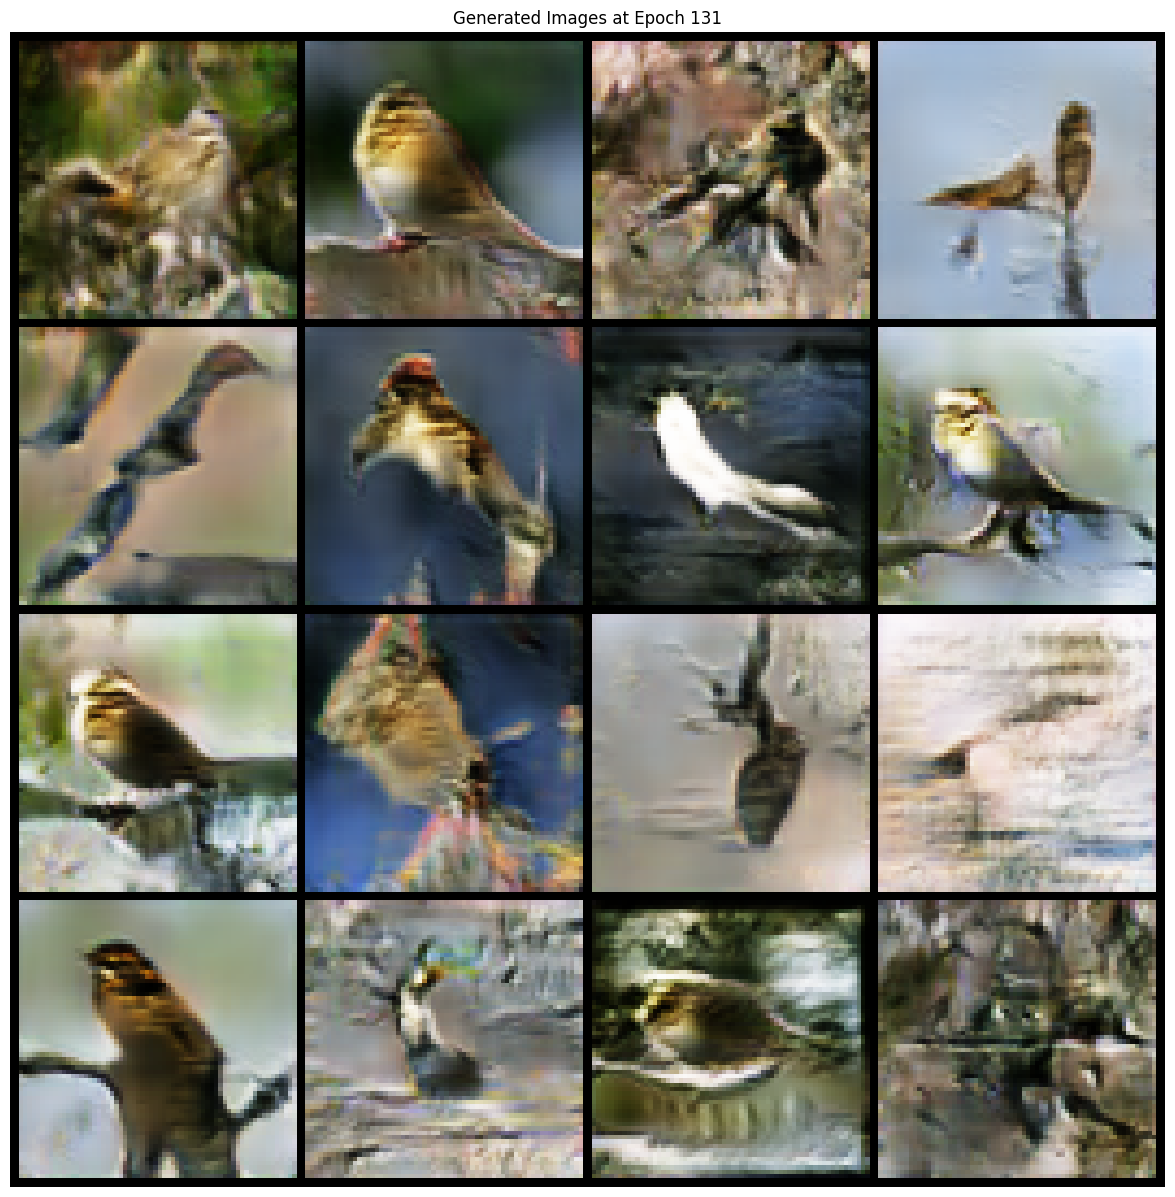

Epoch [132/150], Discriminator Loss: 0.06625087331417653, Generator Loss: 5.049058116918845
Epoch [133/150], Discriminator Loss: 0.11424465340113255, Generator Loss: 5.858243870220596
Epoch [134/150], Discriminator Loss: 0.05702411205836123, Generator Loss: 5.3848932741357265
Epoch [135/150], Discriminator Loss: 0.0376740972622023, Generator Loss: 5.614475601868664
Epoch [136/150], Discriminator Loss: 0.038328206592085336, Generator Loss: 5.728694178217607
Epoch [137/150], Discriminator Loss: 0.02910404136444596, Generator Loss: 6.211471796035767
Epoch [138/150], Discriminator Loss: 0.0476394030098006, Generator Loss: 6.122343915829555
Epoch [139/150], Discriminator Loss: 0.03373985869471627, Generator Loss: 6.225720484479726
Epoch [140/150], Discriminator Loss: 0.03970762911560885, Generator Loss: 6.647296540171123
Epoch [141/150], Discriminator Loss: 0.01935678942919635, Generator Loss: 6.563358739554453


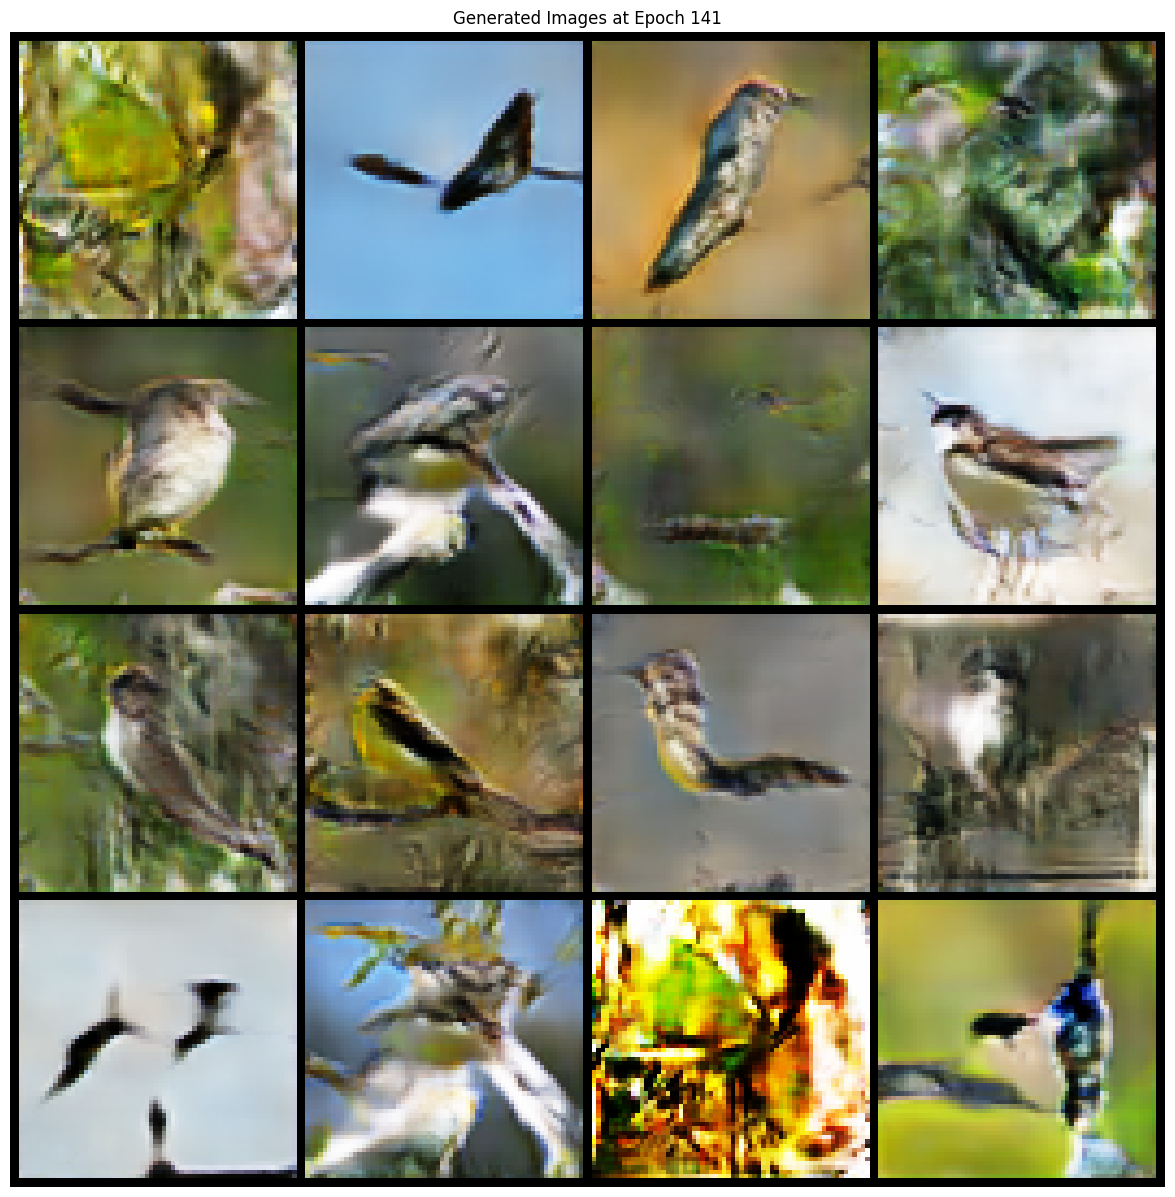

Epoch [142/150], Discriminator Loss: 0.4663857039224973, Generator Loss: 5.630059283414333
Epoch [143/150], Discriminator Loss: 0.14783805017795065, Generator Loss: 5.687711182258112
Epoch [144/150], Discriminator Loss: 0.07917533344555673, Generator Loss: 5.592878613540594
Epoch [145/150], Discriminator Loss: 0.09482119940958328, Generator Loss: 5.717198074721604
Epoch [146/150], Discriminator Loss: 0.15814147988609004, Generator Loss: 6.012798653232108
Epoch [147/150], Discriminator Loss: 0.07103464625802615, Generator Loss: 5.331672238789016
Epoch [148/150], Discriminator Loss: 0.11616445198427323, Generator Loss: 5.943791526952665
Epoch [149/150], Discriminator Loss: 0.158062052041989, Generator Loss: 5.361279047935156
Epoch [150/150], Discriminator Loss: 0.055630314348118125, Generator Loss: 5.695556141489702


2024/10/20 15:00:53 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpj2_diau9/model/data, flavor: pytorch). Fall back to return ['torch==2.4.0', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/10/20 15:00:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/20 15:01:00 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpt15h2mlm/model/data, flavor: pytorch). Fall back to return ['torch==2.4.0', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/10/20 15:01:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR




# Initialize learning rate schedulers
scheduler_g1 = StepLR(opt_g1, step_size=lr_decay_step, gamma=0.5)
scheduler_d1 = StepLR(opt_d1, step_size=lr_decay_step, gamma=0.5)

# MLflow setup
mlflow.set_experiment("GAN_Training_Project")


with mlflow.start_run(run_name="GAN Training Run") as run:
    
    # Get the experiment ID
    experiment_id = run.info.experiment_id
    run_id = run.info.run_id  # Get the current run ID

    # Define the path for saving generated images
    images_folder = f"/kaggle/working/mlruns/{experiment_id}/{run_id}/generated_images"
    
    # Create a directory for the images inside the current run folder
    os.makedirs(images_folder, exist_ok=True)

    # Log hyperparameters
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("learning_rate_g", opt_g1.param_groups[0]['lr'])
    mlflow.log_param("learning_rate_d", opt_d1.param_groups[0]['lr'])
    mlflow.log_param("lr_decay_step", lr_decay_step)
    
    for epoch in range(num_epochs):
        Gen1.train()
        Dis1.train()
        D_loss = []
        G_loss = []

        for real_img, real_embed ,comment in train_loader:
            # Move data to device
            real_img = real_img.to(device)
            real_embed = real_embed.to(device)

            # Generate noise
            noise_d = torch.randn(real_img.size(0), 100).to(device)

            # Train Discriminator
            fake_img_disc, mean_d, var_d = Gen1(real_embed, noise_d)
            fake_img_disc = fake_img_disc.detach()
            mean_d = mean_d.detach()
            var_d = var_d.detach()

            opt_d1.zero_grad()

            real_d1_feature = Dis1(real_img)
            fake_d1_feature = Dis1(fake_img_disc)

            d1_real_op = Dis1.get_cond_logits(real_d1_feature, mean_d)
            d1_fake_op = Dis1.get_cond_logits(fake_d1_feature, mean_d)

            wrong_mean_d = torch.roll(mean_d, 1, 0)
            d1_mislabel_op = Dis1.get_cond_logits(real_d1_feature, wrong_mean_d)

            # Adjusting the real labels to be exactly 1
            real_labels = torch.ones(d1_real_op.shape[0]).to(device)
            fake_labels = torch.zeros(d1_fake_op.shape[0]).to(device)

            dloss_real = criterion(d1_real_op.squeeze(), real_labels)
            dloss_fake = criterion(d1_fake_op.squeeze(), fake_labels)
            dloss_mislabel = criterion(d1_mislabel_op.squeeze(), fake_labels)
            dloss_total =dloss_real + 0.5 * (dloss_fake + dloss_mislabel)

            D_loss.append(dloss_total.item())

            dloss_total.backward()
            opt_d1.step()

            # Train Generator
            opt_g1.zero_grad()

            noise_g = torch.randn(real_img.size(0), 100).to(device)
            fake_img_gen, mean_g, var_g = Gen1(real_embed, noise_g)
            mean_gd = mean_g.detach()

            fake_img_g = Dis1(fake_img_gen)
            g1_fake_op = Dis1.get_cond_logits(fake_img_g, mean_gd)

            real_labels = torch.ones(g1_fake_op.size()).to(device)

            gloss = criterion(g1_fake_op.squeeze(), real_labels)
            kl_loss = KL_loss(mean_gd, var_d)
            g_loss = gloss + kl_loss *  2.0
            G_loss.append(gloss.item())

            gloss.backward()
            opt_g1.step()

        scheduler_g1.step()
        scheduler_d1.step()
        
        # Log losses
        avg_d_loss = np.mean(D_loss)
        avg_g_loss = np.mean(G_loss)
        mlflow.log_metric("Discriminator_Loss", avg_d_loss, step=epoch)
        mlflow.log_metric("Generator_Loss", avg_g_loss, step=epoch)

        print(f'Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {np.mean(D_loss)}, Generator Loss: {np.mean(G_loss)}')
        
        #ploting real and generated images for each epoch 
        Gen1.eval()
        
        # Ensure a folder for images
        os.makedirs(images_folder, exist_ok=True)
        image_path = images_folder + "/epoch_{epoch+1}.png"
        
        if epoch%10==0:
            with torch.no_grad():
                noise = torch.randn(16, 100).to(device)  # Generate noise for 16 images
                sample_embed = real_embed[:16]  # Use the first 16 embeddings

                # Generate images
                generated_images, _, _ = Gen1(sample_embed, noise)

                # Plot real and generated images
                plot_images(generated_images, title=f'Generated Images at Epoch {epoch+1}')
                

                # Use the save_image function or similar to save generated images
                save_image(generated_images, image_path)  # Save the generated images

                # Log the image artifact
                mlflow.log_artifact(image_path, artifact_path="images")
                
                
    
    # Log the model at the end of training
    mlflow.pytorch.log_model(Gen1, "Generator")
    mlflow.pytorch.log_model(Dis1, "Discriminator")

In [23]:
#print(run_id)
from mlflow.tracking import MlflowClient

# Initialize client
mlflow.set_tracking_uri("/kaggle/working/mlruns")
client = MlflowClient()

experiment = client.get_experiment_by_name("GAN_Training_Project")
type(experiment)

# Get all runs
runs = mlflow.search_runs(experiment.experiment_id)
runs

run_id       experiment_id    status  \
0  fd1be8b24e744e1083feb5188a792d9f  857604509768964726  FINISHED   

                                        artifact_uri  \
0  file:///kaggle/working/mlruns/8576045097689647...   

                        start_time                         end_time  \
0 2024-10-20 14:25:03.993000+00:00 2024-10-20 15:01:00.779000+00:00   

   metrics.Discriminator_Loss  metrics.Generator_Loss params.learning_rate_g  \
0                     0.05563                5.695556                 0.0002   

  params.learning_rate_d params.num_epochs params.lr_decay_step  \
0                 0.0002               150                  600   

                       tags.mlflow.log-model.history tags.mlflow.user  \
0  [{"run_id": "fd1be8b24e744e1083feb5188a792d9f"...             root   

  tags.mlflow.source.type tags.mlflow.runName  \
0                   LOCAL    GAN Training Run   

                             tags.mlflow.source.name  
0  /opt/conda/lib/python3.10/site-packages/ipyker...

In [24]:

#generator_model = mlflow.pytorch.load_model("runs:/{run_id}/Generator")
#discriminator_model = mlflow.pytorch.load_model("runs:/{run_id}/Discriminator")

In [25]:
# Save the model's state dictionary
torch.save(Gen1.state_dict(), 'stage1_gen.pth')
torch.save(Dis1.state_dict(), 'stage1_dis.pth')

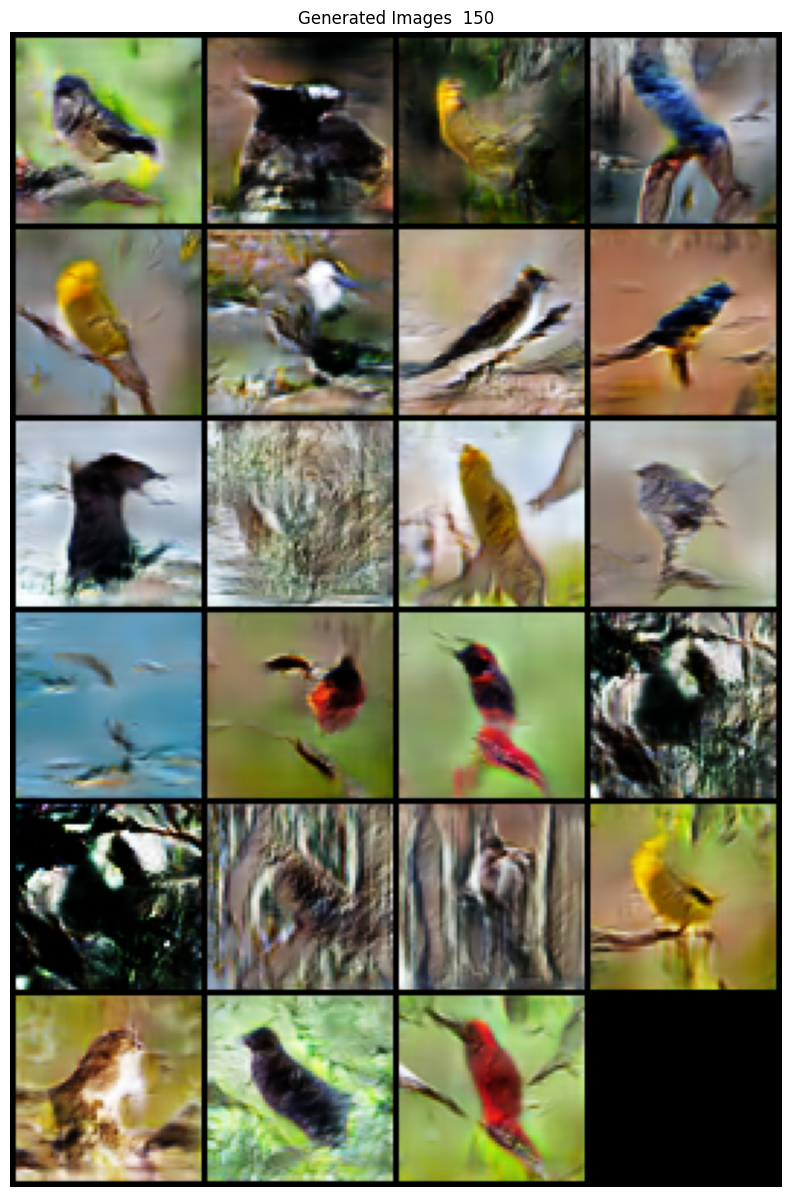

In [26]:
generated_images_list = []

with torch.no_grad():
    for real_img,real_emb,comment in train_loader:
        noise_batch = torch.randn(real_img.size(0), 100).to(device)
        
        sample_embed_batch = real_emb.to(device)
        
        generated_images_batch, _, _ = Gen1(sample_embed_batch, noise_batch)
        
        for_ploting=generated_images_batch.cpu()
        generated_images_np_batch = denormalize(generated_images_batch.cpu())
        generated_images_list.extend(generated_images_np_batch.numpy())
        
plot_images(for_ploting, title=f'Generated Images  {epoch+1}')


In [27]:
train_df['generated_images'] = generated_images_list
train_df.head()

image  \
0  [[[104, 131, 143], [121, 142, 154], [134, 151,...   
1  [[[53, 63, 69], [74, 83, 86], [79, 87, 89], [7...   
2  [[[83, 103, 23], [80, 102, 26], [87, 111, 19],...   
3  [[[150, 148, 153], [153, 151, 156], [155, 153,...   
4  [[[78, 69, 67], [83, 72, 71], [75, 63, 62], [5...   

                                          train_text  \
0  this bird has wings that are brown and has a y...   
1  this bird has wings that are brown and has a y...   
2  this bird has wings that are brown and has a y...   
3  this bird has wings that are brown and has a y...   
4  this bird has wings that are brown and has a y...   

                                          vector_emb  \
0  [-0.20583372, 0.20465058, 0.13165587, -0.06379...   
1  [-0.29646197, 0.1440824, 0.28118563, 0.0293142...   
2  [0.2544848, 0.112521246, 0.056623276, 0.097706...   
3  [-0.15316086, 0.17782697, 0.106462754, -0.0847...   
4  [-0.02236132, -0.025680661, 0.47425216, 0.1033...   

                                    generated_images  
0  [[[0.64722264, 0.6403934, 0.65897286, 0.658761...  
1  [[[0.41859186, 0.37043595, 0.44836277, 0.49530...  
2  [[[0.4172537, 0.34445322, 0.32223576, 0.337868...  
3  [[[0.46862838, 0.48013443, 0.44022995, 0.37016...  
4  [[[0.43544757, 0.32614046, 0.18421867, 0.21543...

In [101]:
train_df.head(1)['train_text'][0]

'this bird has wings that are brown and has a yellow chest'

In [28]:
import pickle

# Exclude the last column and save the DataFrame
with open('/kaggle/working/train_data.pkl', 'wb') as file:
    pickle.dump(train_df.iloc[:, :-1], file)
# Exclude the last column and save the DataFrame
with open('/kaggle/working/test_data.pkl', 'wb') as file:
    pickle.dump(test_df, file)


In [29]:
# Save the DataFrame as a pickle file
with open('/kaggle/working/train_data_after_stage1.pkl', 'wb') as file:
    pickle.dump(train_df, file)

In [88]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet', download_dir='/root/nltk_data')
nltk.download('wordnet', download_dir='/usr/share/nltk_data')
nltk.download('wordnet', download_dir='/usr/local/share/nltk_data')
nltk.download('wordnet', download_dir='/usr/lib/nltk_data')
nltk.download('wordnet', download_dir='/usr/local/lib/nltk_data')
nltk.download('wordnet', download_dir='/usr/share/nltk_data')
nltk.download('wordnet', download_dir='/usr/share/nltk_data')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return tokens

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/lib/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/local/lib/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloadi

In [100]:
import nltk
import zipfile
import os

nltk_data_dir = '/root/nltk_data/wordnet.zip'
unzip_dir = '/root/nltk_data/corpora/wordnet'

if os.path.exists(nltk_data_dir) and not os.path.exists(unzip_dir):
    with zipfile.ZipFile(nltk_data_dir, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)
        print("WordNet corpus unzipped successfully.")
else:
    print("WordNet corpus already unzipped or zip file not found.")

nltk.data.path.append('/root/nltk_data')

# Test if WordNet is now accessible
from nltk.corpus import wordnet
print(wordnet.synsets('bird'))


WordNet corpus already unzipped or zip file not found.
[Synset('bird.n.01'), Synset('bird.n.02'), Synset('dame.n.01'), Synset('boo.n.01'), Synset('shuttlecock.n.01'), Synset('bird.v.01')]


In [91]:
import os

wordnet_dir = '/root/nltk_data/corpora/wordnet'

if os.path.exists(wordnet_dir):
    print("Files in WordNet directory:", os.listdir(wordnet_dir))
else:
    print("WordNet directory not found at", wordnet_dir)


Files in WordNet directory: ['wordnet']


In [92]:
import nltk
import shutil
import zipfile

shutil.rmtree('/root/nltk_data/corpora/wordnet', ignore_errors=True)

nltk.download('wordnet', download_dir='/root/nltk_data')

wordnet_zip = '/root/nltk_data/corpora/wordnet.zip'
if os.path.exists(wordnet_zip):
    with zipfile.ZipFile(wordnet_zip, 'r') as zip_ref:
        zip_ref.extractall('/root/nltk_data/corpora')
        print("WordNet corpus unzipped successfully.")
else:
    print("WordNet zip file not found.")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
WordNet corpus unzipped successfully.


In [93]:
import nltk
nltk.data.path.append('/root/nltk_data')

from nltk.corpus import wordnet
print(wordnet.synsets('bird'))


[Synset('bird.n.01'), Synset('bird.n.02'), Synset('dame.n.01'), Synset('boo.n.01'), Synset('shuttlecock.n.01'), Synset('bird.v.01')]


In [94]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

print(lemmatizer.lemmatize('running'))


running


In [95]:
from collections import Counter

def remove_duplicate_tokens(tokens):
  """Removes duplicate tokens from a list of tokens while preserving order.

  Args:
    tokens: A list of tokens.

  Returns:
    A new list of tokens with duplicates removed.
  """
  unique_tokens = []
  seen_tokens = set()
  for token in tokens:
    if token not in seen_tokens:
      unique_tokens.append(token)
      seen_tokens.add(token)
  return unique_tokens

In [96]:
def train_word2vec(all_tokens):
    sentences = [all_tokens]
    word2vec_model = Word2Vec(sentences, vector_size=1024, window=5, min_count=1, workers=4)
    return word2vec_model

def caption_to_embedding(processed_captions, word2vec_model):
    caption_embeddings = {}
    for caption_file, tokens in processed_captions.items():
        embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
        if embeddings:
            caption_embeddings[caption_file] = np.mean(embeddings, axis=0)
        else:
            caption_embeddings[caption_file] = np.zeros(word2vec_model.vector_size)
    return caption_embeddings

In [97]:
print(nltk.data.path)

['/root/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/usr/share/nltk_data', '/usr/share/nltk_data', '/root/nltk_data', '/root/nltk_data', '/root/nltk_data/corpora', '/root/nltk_data', '/root/nltk_data', '/root/nltk_data', '/root/nltk_data', '/root/nltk_data', '/root/nltk_data']


In [115]:
import nltk
from nltk.corpus import wordnet as wn

lemmatizer = nltk.WordNetLemmatizer()
print(lemmatizer.lemmatize('running'))


running


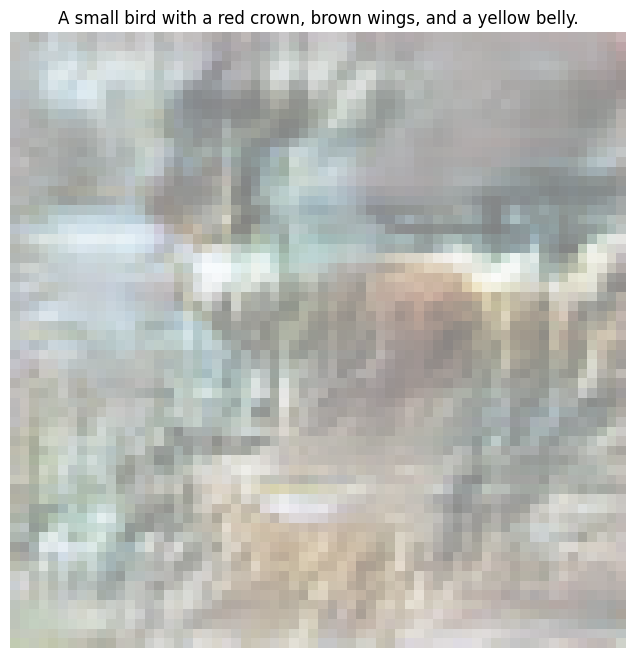

In [114]:

# Function to generate an image from a text input
def generate_image_from_text(text, word2vec_model, gen_model, device='cuda'):
    """
    Generates a single image from text using a trained Word2Vec model and Stage 1 GAN.
    
    Args:
        text (str): The input text caption.
        word2vec_model (gensim.models.Word2Vec): Pre-trained Word2Vec model for embeddings.
        gen_model (torch.nn.Module): Stage 1 GAN model for image generation.
        device (str): Device to run the models ('cuda' or 'cpu').
    
    Returns:
        generated_image_np (numpy array): The generated image as a numpy array.
    """
    tokens = clean_and_tokenize(text)
    tokens = remove_duplicate_tokens(tokens)

    embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if embeddings:
        text_embedding = np.mean(embeddings, axis=0)
    else:
        text_embedding = np.zeros(word2vec_model.vector_size)
    
    text_embedding = torch.tensor(text_embedding).unsqueeze(0).to(device)

    noise = torch.randn(1, 100).to(device)

    with torch.no_grad():
        generated_image, _, _ = Gen1(text_embedding, noise)
    
    generated_image_np = denormalize(generated_image.cpu())
    
    return generated_image_np

text_caption = "A small bird with a red crown, brown wings, and a yellow belly."
processed_text = clean_and_tokenize(text_caption)

word2vec_model = train_word2vec(processed_text)
generated_image = generate_image_from_text(text_caption, word2vec_model, Gen1, device='cuda')

plot_images(generated_image, title=text_caption, figsize=(8,8))

## **Stage2**

In [ ]:
import torch
import torch.nn as nn

class STAGE2_G(nn.Module):
    def __init__(self, device='cuda'):
        super(STAGE2_G, self).__init__()
        self.device = device
        self.ca_net = CA_NET(device=self.device).to(self.device)  # CA Augmentation Network
        self.fc = nn.Linear(1024, 64 * 4 * 4)  # Fully connected layer to project embedding
        self.img_encoder = self.define_image_encoder()
        self.residual_blocks = self.define_residual_blocks()
        self.upsample_layers = self.define_upsample_layers()
        self.final_layer = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def define_image_encoder(self):
        return nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

    def define_residual_blocks(self):
        return nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64)
        )

    def define_upsample_layers(self):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

    def forward(self, embedding, noise):
        # Project the embedding into a 4D shape suitable for Conv2D layers
        x = self.fc(embedding)
        x = x.view(-1, 64, 4, 4)  # Reshape to (batch_size, channels, height, width)

        # Add noise to the projected embedding if necessary
        # You may want to use the noise to perturb the generated output
        x += noise.view(-1, 64, 4, 4)  # Ensure the shape of noise matches

        x = self.img_encoder(x)
        x = self.residual_blocks(x)
        x = self.upsample_layers(x)
        x = self.final_layer(x)
        
        # Compute mean and variance (optional, if needed)
        mean = x.mean(dim=(2, 3), keepdim=True)
        var = x.var(dim=(2, 3), keepdim=True)

        return torch.tanh(x), mean, var  # Return the generated image, mean, and variance


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class STAGE2_D(nn.Module):
    def __init__(self, device='cuda'):
        super(STAGE2_D, self).__init__()
        self.device = device
        self.df_dim = 64  # 64
        self.define_module()

    def define_module(self):
        ndf = self.df_dim  # 64

        # Initial Convolutional Layers
        self.encode_img = nn.Sequential(
            nn.Conv2d(3, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf) x 128 x 128
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*2) x 64 x 64
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*4) x 32 x 32
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*8) x 16 x 16
            nn.Conv2d(ndf * 8, ndf * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*16) x 8 x 8
            nn.Conv2d(ndf * 16, ndf * 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*32) x 4 x 4
        ).to(self.device)

        self.dense_layer = nn.Sequential(
            nn.Conv2d(ndf * 32, ndf * 16, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 16, ndf * 8, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ndf * 8),
        ).to(self.device)

        # Final dense layer for output
        self.final_layer = nn.Sequential(
            nn.Conv2d(ndf * 8, 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        ).to(self.device)

    def forward(self, image, cond_input):
        img_embedding = self.encode_img(image)  # Process the image through the initial layers
        
        # Process the conditional input
        cond_input = cond_input.view(-1, 128, 4, 4)  # Ensure correct input size for concatenation
        added_x = img_embedding + cond_input  # Element-wise addition
        
        dense_output = self.dense_layer(added_x)
        dense_output = F.leaky_relu(dense_output, negative_slope=0.2)  # Apply LeakyReLU

        final_output = self.final_layer(dense_output)  # Final layer to get logits
        return final_output


## **Run for first 100 epochs**

In [ ]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Define the device
num_epochs = 100
lr_decay_step = 600
generator_lr = 2e-4
discriminator_lr = 2e-4

# Instantiate the networks
Gen2 = STAGE2_G(device=device)  # Assuming STAGE2_G is defined similar to STAGE1_G
Gen2.apply(weights_init)  # Initialize the weights

Dis2 = STAGE2_D(device=device)  # Instantiate the Stage 2 Discriminator
Dis2.apply(weights_init)  # Initialize the weights

# Define optimizers
opt_d2 = torch.optim.Adam(Dis2.parameters(), lr=discriminator_lr, betas=(0.5, 0.999))  # For the Discriminator
opt_g2 = torch.optim.Adam(Gen2.parameters(), lr=generator_lr, betas=(0.5, 0.999))  # For the Generator

# Loss function
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
# It compares predicted probabilities with true binary labels and calculates how well the model is performing.


In [ ]:
import torchvision
import matplotlib.pyplot as plt

# Function to denormalize and plot images for Stage 2
def denormalize(tensor):
    """
    Denormalizes the image tensor.

    Args:
        tensor (torch.Tensor): A tensor containing image data normalized to [-1, 1].

    Returns:
        torch.Tensor: Denormalized tensor with values clamped to [0, 1].
    """
    tensor = tensor * 0.5 + 0.5  # Assuming the images were normalized to [-1, 1]
    return tensor.clamp(0, 1)

def plot_images(images, nrow=4, title='Stage 2 Images'):
    """
    Plots a grid of images.

    Args:
        images (torch.Tensor): A tensor of images to plot.
        nrow (int): Number of images in each row.
        title (str): Title for the plot.
    """
    images = denormalize(images)  # Denormalize the images
    grid_img = torchvision.utils.make_grid(images.cpu(), nrow=nrow, padding=2)  # Create a grid
    plt.figure(figsize=(15, 15))  # Set the figure size
    plt.imshow(grid_img.permute(1, 2, 0))  # Permute the tensor for correct display
    plt.title(title)  # Set the title
    plt.axis('off')  # Hide the axes
    plt.show()  # Display the plot

# Example usage
# Assuming fake_images are generated in Stage 2
# fake_images = Gen2(noise)  # Generate images using the Stage 2 generator
# plot_images(fake_images)  # Plot the generated images


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import mlflow
import numpy as np
from torchvision.utils import save_image




    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Define the device
num_epochs = 100
lr_decay_step = 600
generator_lr = 2e-4
discriminator_lr = 2e-4
    
# Load Stage 1 models if already trained and saved
#Gen1.load_state_dict(torch.load('stage1_gen.pth'))  # Load the Stage 1 generator state dictionary
#Dis1.load_state_dict(torch.load('stage1_dis.pth'))  # Load the Stage 1 discriminator state dictionary


# Load Stage 1 models if already trained and saved
Gen1 = torch.load("stage1_gen.pth")  # Load the Stage 1 generator
Dis1 = torch.load("stage1_dis.pth")  # Load the Stage 1 discriminator

# Initialize learning rate schedulers
scheduler_g2 = StepLR(opt_g2, step_size=lr_decay_step, gamma=0.5)
scheduler_d2 = StepLR(opt_d2, step_size=lr_decay_step, gamma=0.5)

# MLflow setup
mlflow.set_experiment("GAN_Training_Project")

with mlflow.start_run(run_name="GAN Stage 2 Training Run") as run:
    # Use the existing experiment ID and run ID from Stage 1
    experiment_id = run.info.experiment_id
    run_id = run.info.run_id  

    # Define the path for saving generated images
    images_folder = f"/kaggle/working/mlruns/{experiment_id}/{run_id}/generated_images"
    
    # Create a directory for the images
    os.makedirs(images_folder, exist_ok=True)

    # Log hyperparameters
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("learning_rate_g", opt_g2.param_groups[0]['lr'])
    mlflow.log_param("learning_rate_d", opt_d2.param_groups[0]['lr'])
    mlflow.log_param("lr_decay_step", lr_decay_step)

    for epoch in range(num_epochs):
        Gen2.train()
        Dis2.train()
        D_loss = []
        G_loss = []

        # Ensure models and inputs are on the correct device
        Gen2 = Gen2.to(device)
        Dis2 = Dis2.to(device)

        for real_img, real_embed, comment in train_loader:
            # Move data and inputs to the device
            real_img = real_img.to(device)
            real_embed = real_embed.to(device)  # Make sure embedding is on the same device
            noise_d = torch.randn(real_img.size(0), 100).to(device)

            # Train Discriminator
            fake_img_disc, mean_d, var_d = Gen2(real_embed, noise_d)  # Ensure Gen2 input is on the device
            fake_img_disc = fake_img_disc.detach()
            mean_d = mean_d.detach()
            var_d = var_d.detach()

            opt_d2.zero_grad()

            real_d2_feature = Dis2(real_img)
            fake_d2_feature = Dis2(fake_img_disc)

            d2_real_op = Dis2.get_cond_logits(real_d2_feature, mean_d)
            d2_fake_op = Dis2.get_cond_logits(fake_d2_feature, mean_d)

            wrong_mean_d = torch.roll(mean_d, 1, 0)
            d2_mislabel_op = Dis2.get_cond_logits(real_d2_feature, wrong_mean_d)

            real_labels = torch.ones(d2_real_op.shape[0]).to(device)
            fake_labels = torch.zeros(d2_fake_op.shape[0]).to(device)

            dloss_real = criterion(d2_real_op.squeeze(), real_labels)
            dloss_fake = criterion(d2_fake_op.squeeze(), fake_labels)
            dloss_mislabel = criterion(d2_mislabel_op.squeeze(), fake_labels)
            dloss_total = dloss_real + 0.5 * (dloss_fake + dloss_mislabel)

            D_loss.append(dloss_total.item())

            dloss_total.backward()
            opt_d2.step()


        scheduler_g2.step()
        scheduler_d2.step()
        
        # Log losses
        avg_d_loss = np.mean(D_loss)
        avg_g_loss = np.mean(G_loss)
        mlflow.log_metric("Discriminator_Loss", avg_d_loss, step=epoch)
        mlflow.log_metric("Generator_Loss", avg_g_loss, step=epoch)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Discriminator Loss: {avg_d_loss}, Generator Loss: {avg_g_loss}')
        
        # Plotting real and generated images for each epoch 
        Gen2.eval()
        
        # Ensure a folder for images
        os.makedirs(images_folder, exist_ok=True)
        image_path = os.path.join(images_folder, f"epoch_{epoch + 1}.png")
        
        if epoch % 10 == 0:
             with torch.no_grad():
                noise = torch.randn(16, 100).to(device)  # Generate noise for 16 images
                sample_embed = real_embed[:16].to(device)  # Use the first 16 embeddings and ensure they are moved to the device

                # Generate images
                generated_images, _, _ = Gen2(sample_embed, noise)

                # Save the generated images
                save_image(generated_images, image_path)

                # Log the image artifact
                mlflow.log_artifact(image_path, artifact_path="images")
                
    # Log the model at the end of training
    mlflow.pytorch.log_model(Gen2, "Generator")
    mlflow.pytorch.log_model(Dis2, "Discriminator")


In [ ]:
import torch.optim as optim
import torch

# Hyperparameters
lr = 0.0002
betas = (0.5, 0.999)
num_epochs = 200
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss function
adversarial_loss = nn.BCELoss()

# Create generator and discriminator
stage2_generator = STAGE2_G(ngf=128, noise_dim=100, embed_dim=128).to(device)
stage2_discriminator = STAGE2_D(df_dim=64, ef_dim=128).to(device)

# Optimizers
optimizer_G = optim.Adam(stage2_generator.parameters(), lr=lr, betas=betas)
optimizer_D = optim.Adam(stage2_discriminator.parameters(), lr=lr, betas=betas)

# Labels for real and fake images
real_labels = torch.ones(batch_size).to(device)
fake_labels = torch.zeros(batch_size).to(device)

# Sample data (replace with actual dataloader)
train_loader = [ (torch.randn(batch_size, 3, 256, 256), torch.randn(batch_size, 128)) for _ in range(100) ]

# Training loop
for epoch in range(num_epochs):
    for i, (real_images, real_embeds) in enumerate(train_loader):
        real_images, real_embeds = real_images.to(device), real_embeds.to(device)

        ######################
        # 1. Update Discriminator
        ######################
        optimizer_D.zero_grad()

        # Train with real images
        real_output = stage2_discriminator(real_images, real_embeds)
        d_loss_real = adversarial_loss(real_output, real_labels)

        # Generate fake images
        noise = torch.randn(batch_size, 100).to(device)
        fake_images = stage2_generator(real_embeds, noise)

        # Train with fake images
        fake_output = stage2_discriminator(fake_images.detach(), real_embeds)
        d_loss_fake = adversarial_loss(fake_output, fake_labels)

        # Total discriminator loss
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        ######################
        # 2. Update Generator
        ######################
        optimizer_G.zero_grad()

        # Generator loss: try to fool the discriminator
        fake_output = stage2_discriminator(fake_images, real_embeds)
        g_loss = adversarial_loss(fake_output, real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Print progress
        if i % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')


In [ ]:
# Create generator and discriminator
stage2_generator = STAGE2_G(ngf=128, noise_dim=100, embed_dim=128).to(device)
stage2_discriminator = STAGE2_D(df_dim=64, ef_dim=128).to(device)

# Generate fake images
noise = torch.randn(batch_size, 100).to(device)
text_embedding = torch.randn(batch_size, 128).to(device)

# Forward pass through the generator
fake_images, mu, logvar = stage2_generator(text_embedding, noise)

# Forward pass through the discriminator
d_output = stage2_discriminator(fake_images, text_embedding)
print(d_output.shape)  # Should be [batch_size] (i.e., real/fake classification for each image)
